This notebook calculates the Mahalanobis distance between points on a pca. 
I will document more about what Mahalanobis distance is and how it is calculated in this notebook.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial.distance import mahalanobis
from scipy.stats import f_oneway as anova
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# set the path to the data
sum_aggregated_data_pca_path = pathlib.Path(
    "../../data/6.analysis_results/sum_aggregated_pca.parquet"
).resolve(strict=True)

# read the data
sum_aggregated_data_pca = pd.read_parquet(sum_aggregated_data_pca_path)
print(sum_aggregated_data_pca.shape)
sum_aggregated_data_pca.head()

(83, 86)


,Metadata_genotype,Metadata_replicate,Metadata_side,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83
0,High-Severity,1,L,-4.119483,1.991218,0.303879,-1.684469,2.612682,-3.209001,3.797245,...,-0.024596,-0.135772,-0.032539,-0.117004,0.379927,0.055097,0.020213,0.171419,-0.038079,-2.315274e-16
1,High-Severity,1,R,-0.216856,-6.465370,1.138630,-1.419515,0.734994,0.286382,-1.947202,...,0.352484,0.491001,0.066891,-0.412823,0.171996,-0.254966,-0.137621,0.301330,-0.202659,-1.327045e-15
2,High-Severity,10,L,3.037171,-9.309422,2.331700,-2.247219,-1.799904,1.185632,-2.196101,...,-0.091030,-0.036167,-0.421525,0.309394,-0.645142,-0.057501,-0.154886,-0.185996,-0.299166,-2.523921e-15
3,High-Severity,10,R,0.812527,-5.060089,2.102814,0.003530,-0.285134,1.160509,-2.081840,...,0.249178,-0.249715,0.443153,-0.144278,-0.577923,-0.062862,0.625753,-0.223723,0.165455,-1.249731e-15
4,High-Severity,11,L,0.186089,-8.703921,0.058820,-1.604671,2.038516,-2.165193,4.044708,...,0.143239,-0.143268,-0.037719,-0.108338,-0.290040,0.009491,0.024692,-0.036455,0.050904,9.182966e-16


# Mahalanobis Distance
For more in depth information on Mahalanobis distance, please refer to this [link](https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099).
Mahalanobis distance is a measure of the distance between a point P and a distribution D. 
It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. 
This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis.
The formula for Mahalanobis distance is given by:
### $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
where:
- $D$ is the Mahalanobis distance

## Caluclating Mahalanobis Distance on PCA 
Here I calculate the Mahalanobis distance between the points on the first two principal components of the data for each of the three genotypes.

In [3]:
# split the genotypes
high_severity = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "High-Severity"
]
low_severity = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "Mid-Severity"
]
wt = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "Wild Type"
]
print(len(high_severity), len(low_severity), len(wt))

28 27 28


In [4]:
# drop the the Metadata columns
metadata_columns = high_severity.columns[high_severity.columns.str.contains("Metadata")]
high_severity = high_severity.drop(metadata_columns, axis=1)
low_severity = low_severity.drop(metadata_columns, axis=1)
wt = wt.drop(metadata_columns, axis=1)


# convert the df to coordinates
high_severity_coords = high_severity.to_numpy()
low_severity_coords = low_severity.to_numpy()
wt_coords = wt.to_numpy()
print(high_severity_coords.shape, low_severity_coords.shape, wt_coords.shape)

(28, 83) (27, 83) (28, 83)


#### High-Severity

In [5]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(high_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
high_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point combination
for point in itertools.combinations(high_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    high_severity_mahalanobis_distances.append(distance)
mean_high_severity_mahalanobis_distance = np.mean(high_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the High-Severity genotype is {mean_high_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the High-Severity genotype is 13.454875980757157


/home/lippincm/miniforge3/envs/op_cell_processing_env/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


#### Low-Severity

In [6]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(low_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
low_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(low_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    low_severity_mahalanobis_distances.append(distance)
mean_low_severity_mahalanobis_distance = np.mean(low_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the low-Severity genotype is {mean_low_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the low-Severity genotype is 12.876674389086938


#### Wild Type

In [7]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(wt_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
wt_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(wt_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    wt_mahalanobis_distances.append(distance)
mean_wt_mahalanobis_distance = np.mean(wt_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the Wild Type genotype is {mean_wt_mahalanobis_distance}"
)

The mean mahalanobis distance for the Wild Type genotype is 8.917734153240842


## Calculate the Mahalanobis distance for random shuffled data points

In [8]:
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance
# get the distribution of each PCA component
high_severity_pca_component_distribution_std = high_severity.describe().loc["std"]
low_severity_pca_component_distribution_std = low_severity.describe().loc["std"]
wt_pca_component_distribution_std = wt.describe().loc["std"]

high_severity_pca_component_distribution_mean = high_severity.describe().loc["mean"]
low_severity_pca_component_distribution_mean = low_severity.describe().loc["mean"]
wt_pca_component_distribution_mean = wt.describe().loc["mean"]

In [9]:
# do 1000 trials of sampling from each PCA component distribution
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance

# set the output mean Mahalanobis distance lists per genotype
mean_high_severity_sampled_mahalanobis_distances_from_trials = []
mean_low_severity_sampled_mahalanobis_distances_from_trials = []
mean_wt_sampled_mahalanobis_distances_from_trials = []

# sample 1000 points from the distribution of each PCA component
num_pca_components = high_severity_pca_component_distribution_std.shape[0]
num_samples = 100
num_trials = 1000

for trial in tqdm.tqdm(range(num_trials)):
    high_severity_sampled_points = pd.DataFrame()
    low_severity_sampled_points = pd.DataFrame()
    wt_sampled_points = pd.DataFrame()

    for i in range(num_pca_components):
        high_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=high_severity_pca_component_distribution_mean[i],
            scale=high_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        low_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=low_severity_pca_component_distribution_mean[i],
            scale=low_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        wt_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=wt_pca_component_distribution_mean[i],
            scale=wt_pca_component_distribution_std[i],
            size=num_samples,
        )

    inv_cov_matrix = np.linalg.inv(
        np.cov(high_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    high_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(high_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        high_severity_sampled_mahalanobis_distances.append(distance)

    mean_high_severity_sampled_mahalanobis_distance = np.mean(
        high_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(
        np.cov(low_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    low_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(low_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        low_severity_sampled_mahalanobis_distances.append(distance)

    mean_low_severity_sampled_mahalanobis_distance = np.mean(
        low_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(np.cov(wt_sampled_points.to_numpy(), rowvar=False))
    # calculate the mahalanobis distance for each point within each genotype
    wt_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(wt_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        wt_sampled_mahalanobis_distances.append(distance)

    mean_wt_sampled_mahalanobis_distance = np.mean(wt_sampled_mahalanobis_distances)

    # append the average mahalanobis distance from the trial to the list for the trial per genotype
    mean_high_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_high_severity_sampled_mahalanobis_distance
    )
    mean_low_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_low_severity_sampled_mahalanobis_distance
    )
    mean_wt_sampled_mahalanobis_distances_from_trials.append(
        mean_wt_sampled_mahalanobis_distance
    )

  0%|                                                                                        | 0/1000 [00:00<?, ?it/s]

  0%|                                                                                | 1/1000 [00:00<02:41,  6.20it/s]

  0%|▏                                                                               | 2/1000 [00:00<02:45,  6.02it/s]

  0%|▏                                                                               | 3/1000 [00:00<02:47,  5.94it/s]

  0%|▎                                                                               | 4/1000 [00:00<02:48,  5.90it/s]

  0%|▍                                                                               | 5/1000 [00:00<02:49,  5.88it/s]

  1%|▍                                                                               | 6/1000 [00:01<02:50,  5.85it/s]

  1%|▌                                                                               | 7/1000 [00:01<02:49,  5.85it/s]

  1%|▋                                                                               | 8/1000 [00:01<02:49,  5.85it/s]

  1%|▋                                                                               | 9/1000 [00:01<02:49,  5.84it/s]

  1%|▊                                                                              | 10/1000 [00:01<02:49,  5.84it/s]

  1%|▊                                                                              | 11/1000 [00:01<02:49,  5.84it/s]

  1%|▉                                                                              | 12/1000 [00:02<02:49,  5.84it/s]

  1%|█                                                                              | 13/1000 [00:02<02:49,  5.83it/s]

  1%|█                                                                              | 14/1000 [00:02<02:48,  5.84it/s]

  2%|█▏                                                                             | 15/1000 [00:02<02:49,  5.80it/s]

  2%|█▎                                                                             | 16/1000 [00:02<02:49,  5.80it/s]

  2%|█▎                                                                             | 17/1000 [00:02<02:48,  5.82it/s]

  2%|█▍                                                                             | 18/1000 [00:03<02:48,  5.84it/s]

  2%|█▌                                                                             | 19/1000 [00:03<02:48,  5.83it/s]

  2%|█▌                                                                             | 20/1000 [00:03<02:48,  5.83it/s]

  2%|█▋                                                                             | 21/1000 [00:03<02:48,  5.83it/s]

  2%|█▋                                                                             | 22/1000 [00:03<02:48,  5.82it/s]

  2%|█▊                                                                             | 23/1000 [00:03<02:47,  5.83it/s]

  2%|█▉                                                                             | 24/1000 [00:04<02:47,  5.84it/s]

  2%|█▉                                                                             | 25/1000 [00:04<02:47,  5.82it/s]

  3%|██                                                                             | 26/1000 [00:04<02:47,  5.82it/s]

  3%|██▏                                                                            | 27/1000 [00:04<02:47,  5.82it/s]

  3%|██▏                                                                            | 28/1000 [00:04<02:47,  5.81it/s]

  3%|██▎                                                                            | 29/1000 [00:04<02:46,  5.82it/s]

  3%|██▎                                                                            | 30/1000 [00:05<02:46,  5.83it/s]

  3%|██▍                                                                            | 31/1000 [00:05<02:46,  5.83it/s]

  3%|██▌                                                                            | 32/1000 [00:05<02:46,  5.82it/s]

  3%|██▌                                                                            | 33/1000 [00:05<02:45,  5.83it/s]

  3%|██▋                                                                            | 34/1000 [00:05<02:46,  5.81it/s]

  4%|██▊                                                                            | 35/1000 [00:05<02:46,  5.81it/s]

  4%|██▊                                                                            | 36/1000 [00:06<02:45,  5.82it/s]

  4%|██▉                                                                            | 37/1000 [00:06<02:45,  5.83it/s]

  4%|███                                                                            | 38/1000 [00:06<02:45,  5.81it/s]

  4%|███                                                                            | 39/1000 [00:06<02:45,  5.82it/s]

  4%|███▏                                                                           | 40/1000 [00:06<02:45,  5.81it/s]

  4%|███▏                                                                           | 41/1000 [00:07<02:44,  5.82it/s]

  4%|███▎                                                                           | 42/1000 [00:07<02:44,  5.81it/s]

  4%|███▍                                                                           | 43/1000 [00:07<02:44,  5.82it/s]

  4%|███▍                                                                           | 44/1000 [00:07<02:44,  5.82it/s]

  4%|███▌                                                                           | 45/1000 [00:07<02:44,  5.82it/s]

  5%|███▋                                                                           | 46/1000 [00:07<02:44,  5.82it/s]

  5%|███▋                                                                           | 47/1000 [00:08<02:43,  5.83it/s]

  5%|███▊                                                                           | 48/1000 [00:08<02:43,  5.83it/s]

  5%|███▊                                                                           | 49/1000 [00:08<02:43,  5.83it/s]

  5%|███▉                                                                           | 50/1000 [00:08<02:43,  5.83it/s]

  5%|████                                                                           | 51/1000 [00:08<02:42,  5.83it/s]

  5%|████                                                                           | 52/1000 [00:08<02:42,  5.83it/s]

  5%|████▏                                                                          | 53/1000 [00:09<02:42,  5.84it/s]

  5%|████▎                                                                          | 54/1000 [00:09<02:42,  5.83it/s]

  6%|████▎                                                                          | 55/1000 [00:09<02:42,  5.83it/s]

  6%|████▍                                                                          | 56/1000 [00:09<02:42,  5.82it/s]

  6%|████▌                                                                          | 57/1000 [00:09<02:42,  5.82it/s]

  6%|████▌                                                                          | 58/1000 [00:09<02:41,  5.83it/s]

  6%|████▋                                                                          | 59/1000 [00:10<02:41,  5.83it/s]

  6%|████▋                                                                          | 60/1000 [00:10<02:41,  5.82it/s]

  6%|████▊                                                                          | 61/1000 [00:10<02:41,  5.81it/s]

  6%|████▉                                                                          | 62/1000 [00:10<02:41,  5.81it/s]

  6%|████▉                                                                          | 63/1000 [00:10<02:41,  5.81it/s]

  6%|█████                                                                          | 64/1000 [00:10<02:41,  5.81it/s]

  6%|█████▏                                                                         | 65/1000 [00:11<02:41,  5.80it/s]

  7%|█████▏                                                                         | 66/1000 [00:11<02:41,  5.79it/s]

  7%|█████▎                                                                         | 67/1000 [00:11<02:41,  5.78it/s]

  7%|█████▎                                                                         | 68/1000 [00:11<02:40,  5.80it/s]

  7%|█████▍                                                                         | 69/1000 [00:11<02:40,  5.80it/s]

  7%|█████▌                                                                         | 70/1000 [00:12<02:40,  5.80it/s]

  7%|█████▌                                                                         | 71/1000 [00:12<02:39,  5.81it/s]

  7%|█████▋                                                                         | 72/1000 [00:12<02:39,  5.80it/s]

  7%|█████▊                                                                         | 73/1000 [00:12<02:39,  5.82it/s]

  7%|█████▊                                                                         | 74/1000 [00:12<02:39,  5.81it/s]

  8%|█████▉                                                                         | 75/1000 [00:12<02:39,  5.81it/s]

  8%|██████                                                                         | 76/1000 [00:13<02:38,  5.82it/s]

  8%|██████                                                                         | 77/1000 [00:13<02:39,  5.80it/s]

  8%|██████▏                                                                        | 78/1000 [00:13<02:38,  5.81it/s]

  8%|██████▏                                                                        | 79/1000 [00:13<02:38,  5.81it/s]

  8%|██████▎                                                                        | 80/1000 [00:13<02:38,  5.81it/s]

  8%|██████▍                                                                        | 81/1000 [00:13<02:38,  5.81it/s]

  8%|██████▍                                                                        | 82/1000 [00:14<02:37,  5.83it/s]

  8%|██████▌                                                                        | 83/1000 [00:14<02:37,  5.82it/s]

  8%|██████▋                                                                        | 84/1000 [00:14<02:37,  5.82it/s]

  8%|██████▋                                                                        | 85/1000 [00:14<02:37,  5.82it/s]

  9%|██████▊                                                                        | 86/1000 [00:14<02:37,  5.81it/s]

  9%|██████▊                                                                        | 87/1000 [00:14<02:37,  5.81it/s]

  9%|██████▉                                                                        | 88/1000 [00:15<02:36,  5.82it/s]

  9%|███████                                                                        | 89/1000 [00:15<02:36,  5.81it/s]

  9%|███████                                                                        | 90/1000 [00:15<02:36,  5.81it/s]

  9%|███████▏                                                                       | 91/1000 [00:15<02:36,  5.81it/s]

  9%|███████▎                                                                       | 92/1000 [00:15<02:36,  5.80it/s]

  9%|███████▎                                                                       | 93/1000 [00:15<02:36,  5.81it/s]

  9%|███████▍                                                                       | 94/1000 [00:16<02:35,  5.82it/s]

 10%|███████▌                                                                       | 95/1000 [00:16<02:35,  5.81it/s]

 10%|███████▌                                                                       | 96/1000 [00:16<02:35,  5.82it/s]

 10%|███████▋                                                                       | 97/1000 [00:16<02:36,  5.78it/s]

 10%|███████▋                                                                       | 98/1000 [00:16<02:35,  5.79it/s]

 10%|███████▊                                                                       | 99/1000 [00:17<02:35,  5.80it/s]

 10%|███████▊                                                                      | 100/1000 [00:17<02:35,  5.77it/s]

 10%|███████▉                                                                      | 101/1000 [00:17<02:35,  5.78it/s]

 10%|███████▉                                                                      | 102/1000 [00:17<02:35,  5.79it/s]

 10%|████████                                                                      | 103/1000 [00:17<02:34,  5.79it/s]

 10%|████████                                                                      | 104/1000 [00:17<02:34,  5.80it/s]

 10%|████████▏                                                                     | 105/1000 [00:18<02:33,  5.82it/s]

 11%|████████▎                                                                     | 106/1000 [00:18<02:33,  5.82it/s]

 11%|████████▎                                                                     | 107/1000 [00:18<02:33,  5.81it/s]

 11%|████████▍                                                                     | 108/1000 [00:18<02:33,  5.80it/s]

 11%|████████▌                                                                     | 109/1000 [00:18<02:33,  5.81it/s]

 11%|████████▌                                                                     | 110/1000 [00:18<02:33,  5.81it/s]

 11%|████████▋                                                                     | 111/1000 [00:19<02:32,  5.81it/s]

 11%|████████▋                                                                     | 112/1000 [00:19<02:32,  5.82it/s]

 11%|████████▊                                                                     | 113/1000 [00:19<02:35,  5.71it/s]

 11%|████████▉                                                                     | 114/1000 [00:19<02:34,  5.75it/s]

 12%|████████▉                                                                     | 115/1000 [00:19<02:33,  5.78it/s]

 12%|█████████                                                                     | 116/1000 [00:19<02:35,  5.69it/s]

 12%|█████████▏                                                                    | 117/1000 [00:20<02:34,  5.73it/s]

 12%|█████████▏                                                                    | 118/1000 [00:20<02:33,  5.76it/s]

 12%|█████████▎                                                                    | 119/1000 [00:20<02:32,  5.78it/s]

 12%|█████████▎                                                                    | 120/1000 [00:20<02:34,  5.70it/s]

 12%|█████████▍                                                                    | 121/1000 [00:20<02:33,  5.74it/s]

 12%|█████████▌                                                                    | 122/1000 [00:20<02:32,  5.76it/s]

 12%|█████████▌                                                                    | 123/1000 [00:21<02:31,  5.78it/s]

 12%|█████████▋                                                                    | 124/1000 [00:21<02:30,  5.81it/s]

 12%|█████████▊                                                                    | 125/1000 [00:21<02:30,  5.82it/s]

 13%|█████████▊                                                                    | 126/1000 [00:21<02:29,  5.83it/s]

 13%|█████████▉                                                                    | 127/1000 [00:21<02:29,  5.83it/s]

 13%|█████████▉                                                                    | 128/1000 [00:22<02:29,  5.83it/s]

 13%|██████████                                                                    | 129/1000 [00:22<02:29,  5.83it/s]

 13%|██████████▏                                                                   | 130/1000 [00:22<02:29,  5.83it/s]

 13%|██████████▏                                                                   | 131/1000 [00:22<02:28,  5.85it/s]

 13%|██████████▎                                                                   | 132/1000 [00:22<02:28,  5.85it/s]

 13%|██████████▎                                                                   | 133/1000 [00:22<02:28,  5.85it/s]

 13%|██████████▍                                                                   | 134/1000 [00:23<02:28,  5.85it/s]

 14%|██████████▌                                                                   | 135/1000 [00:23<02:28,  5.83it/s]

 14%|██████████▌                                                                   | 136/1000 [00:23<02:28,  5.83it/s]

 14%|██████████▋                                                                   | 137/1000 [00:23<02:27,  5.84it/s]

 14%|██████████▊                                                                   | 138/1000 [00:23<02:27,  5.86it/s]

 14%|██████████▊                                                                   | 139/1000 [00:23<02:27,  5.85it/s]

 14%|██████████▉                                                                   | 140/1000 [00:24<02:26,  5.85it/s]

 14%|██████████▉                                                                   | 141/1000 [00:24<02:26,  5.85it/s]

 14%|███████████                                                                   | 142/1000 [00:24<02:26,  5.85it/s]

 14%|███████████▏                                                                  | 143/1000 [00:24<02:27,  5.82it/s]

 14%|███████████▏                                                                  | 144/1000 [00:24<02:27,  5.82it/s]

 14%|███████████▎                                                                  | 145/1000 [00:24<02:27,  5.80it/s]

 15%|███████████▍                                                                  | 146/1000 [00:25<02:26,  5.81it/s]

 15%|███████████▍                                                                  | 147/1000 [00:25<02:26,  5.81it/s]

 15%|███████████▌                                                                  | 148/1000 [00:25<02:26,  5.80it/s]

 15%|███████████▌                                                                  | 149/1000 [00:25<02:26,  5.80it/s]

 15%|███████████▋                                                                  | 150/1000 [00:25<02:26,  5.78it/s]

 15%|███████████▊                                                                  | 151/1000 [00:25<02:27,  5.78it/s]

 15%|███████████▊                                                                  | 152/1000 [00:26<02:26,  5.78it/s]

 15%|███████████▉                                                                  | 153/1000 [00:26<02:26,  5.79it/s]

 15%|████████████                                                                  | 154/1000 [00:26<02:26,  5.79it/s]

 16%|████████████                                                                  | 155/1000 [00:26<02:26,  5.78it/s]

 16%|████████████▏                                                                 | 156/1000 [00:26<02:25,  5.78it/s]

 16%|████████████▏                                                                 | 157/1000 [00:27<02:25,  5.79it/s]

 16%|████████████▎                                                                 | 158/1000 [00:27<02:25,  5.78it/s]

 16%|████████████▍                                                                 | 159/1000 [00:27<02:25,  5.78it/s]

 16%|████████████▍                                                                 | 160/1000 [00:27<02:25,  5.78it/s]

 16%|████████████▌                                                                 | 161/1000 [00:27<02:25,  5.78it/s]

 16%|████████████▋                                                                 | 162/1000 [00:27<02:25,  5.77it/s]

 16%|████████████▋                                                                 | 163/1000 [00:28<02:24,  5.78it/s]

 16%|████████████▊                                                                 | 164/1000 [00:28<02:24,  5.78it/s]

 16%|████████████▊                                                                 | 165/1000 [00:28<02:24,  5.78it/s]

 17%|████████████▉                                                                 | 166/1000 [00:28<02:24,  5.77it/s]

 17%|█████████████                                                                 | 167/1000 [00:28<02:24,  5.78it/s]

 17%|█████████████                                                                 | 168/1000 [00:28<02:23,  5.79it/s]

 17%|█████████████▏                                                                | 169/1000 [00:29<02:23,  5.80it/s]

 17%|█████████████▎                                                                | 170/1000 [00:29<02:23,  5.80it/s]

 17%|█████████████▎                                                                | 171/1000 [00:29<02:22,  5.80it/s]

 17%|█████████████▍                                                                | 172/1000 [00:29<02:33,  5.41it/s]

 17%|█████████████▍                                                                | 173/1000 [00:29<02:25,  5.67it/s]

 17%|█████████████▌                                                                | 174/1000 [00:29<02:24,  5.71it/s]

 18%|█████████████▋                                                                | 175/1000 [00:30<02:23,  5.74it/s]

 18%|█████████████▋                                                                | 176/1000 [00:30<02:25,  5.66it/s]

 18%|█████████████▊                                                                | 177/1000 [00:30<02:24,  5.70it/s]

 18%|█████████████▉                                                                | 178/1000 [00:30<02:23,  5.72it/s]

 18%|█████████████▉                                                                | 179/1000 [00:30<02:22,  5.74it/s]

 18%|██████████████                                                                | 180/1000 [00:31<02:22,  5.75it/s]

 18%|██████████████                                                                | 181/1000 [00:31<02:22,  5.76it/s]

 18%|██████████████▏                                                               | 182/1000 [00:31<02:21,  5.77it/s]

 18%|██████████████▎                                                               | 183/1000 [00:31<02:21,  5.78it/s]

 18%|██████████████▎                                                               | 184/1000 [00:31<02:21,  5.78it/s]

 18%|██████████████▍                                                               | 185/1000 [00:31<02:20,  5.79it/s]

 19%|██████████████▌                                                               | 186/1000 [00:32<02:20,  5.79it/s]

 19%|██████████████▌                                                               | 187/1000 [00:32<02:20,  5.79it/s]

 19%|██████████████▋                                                               | 188/1000 [00:32<02:20,  5.79it/s]

 19%|██████████████▋                                                               | 189/1000 [00:32<02:20,  5.79it/s]

 19%|██████████████▊                                                               | 190/1000 [00:32<02:20,  5.78it/s]

 19%|██████████████▉                                                               | 191/1000 [00:32<02:19,  5.79it/s]

 19%|██████████████▉                                                               | 192/1000 [00:33<02:19,  5.80it/s]

 19%|███████████████                                                               | 193/1000 [00:33<02:19,  5.80it/s]

 19%|███████████████▏                                                              | 194/1000 [00:33<02:19,  5.79it/s]

 20%|███████████████▏                                                              | 195/1000 [00:33<02:19,  5.79it/s]

 20%|███████████████▎                                                              | 196/1000 [00:33<02:19,  5.78it/s]

 20%|███████████████▎                                                              | 197/1000 [00:33<02:18,  5.78it/s]

 20%|███████████████▍                                                              | 198/1000 [00:34<02:41,  4.97it/s]

 20%|███████████████▌                                                              | 199/1000 [00:34<02:50,  4.71it/s]

 20%|███████████████▌                                                              | 200/1000 [00:34<02:41,  4.96it/s]

 20%|███████████████▋                                                              | 201/1000 [00:34<02:34,  5.17it/s]

 20%|███████████████▊                                                              | 202/1000 [00:34<02:29,  5.34it/s]

 20%|███████████████▊                                                              | 203/1000 [00:35<02:25,  5.48it/s]

 20%|███████████████▉                                                              | 204/1000 [00:35<02:23,  5.56it/s]

 20%|███████████████▉                                                              | 205/1000 [00:35<02:21,  5.63it/s]

 21%|████████████████                                                              | 206/1000 [00:35<02:19,  5.67it/s]

 21%|████████████████▏                                                             | 207/1000 [00:35<02:19,  5.70it/s]

 21%|████████████████▏                                                             | 208/1000 [00:36<02:18,  5.72it/s]

 21%|████████████████▎                                                             | 209/1000 [00:36<02:18,  5.73it/s]

 21%|████████████████▍                                                             | 210/1000 [00:36<02:17,  5.75it/s]

 21%|████████████████▍                                                             | 211/1000 [00:36<02:17,  5.75it/s]

 21%|████████████████▌                                                             | 212/1000 [00:36<02:16,  5.76it/s]

 21%|████████████████▌                                                             | 213/1000 [00:36<02:16,  5.76it/s]

 21%|████████████████▋                                                             | 214/1000 [00:37<02:16,  5.77it/s]

 22%|████████████████▊                                                             | 215/1000 [00:37<02:16,  5.76it/s]

 22%|████████████████▊                                                             | 216/1000 [00:37<02:15,  5.77it/s]

 22%|████████████████▉                                                             | 217/1000 [00:37<02:15,  5.76it/s]

 22%|█████████████████                                                             | 218/1000 [00:37<02:15,  5.76it/s]

 22%|█████████████████                                                             | 219/1000 [00:37<02:15,  5.76it/s]

 22%|█████████████████▏                                                            | 220/1000 [00:38<02:15,  5.78it/s]

 22%|█████████████████▏                                                            | 221/1000 [00:38<02:14,  5.78it/s]

 22%|█████████████████▎                                                            | 222/1000 [00:38<02:14,  5.79it/s]

 22%|█████████████████▍                                                            | 223/1000 [00:38<02:14,  5.78it/s]

 22%|█████████████████▍                                                            | 224/1000 [00:38<02:14,  5.78it/s]

 22%|█████████████████▌                                                            | 225/1000 [00:38<02:14,  5.77it/s]

 23%|█████████████████▋                                                            | 226/1000 [00:39<02:14,  5.77it/s]

 23%|█████████████████▋                                                            | 227/1000 [00:39<02:13,  5.77it/s]

 23%|█████████████████▊                                                            | 228/1000 [00:39<02:13,  5.77it/s]

 23%|█████████████████▊                                                            | 229/1000 [00:39<02:13,  5.78it/s]

 23%|█████████████████▉                                                            | 230/1000 [00:39<02:13,  5.78it/s]

 23%|██████████████████                                                            | 231/1000 [00:39<02:13,  5.78it/s]

 23%|██████████████████                                                            | 232/1000 [00:40<02:12,  5.78it/s]

 23%|██████████████████▏                                                           | 233/1000 [00:40<02:12,  5.78it/s]

 23%|██████████████████▎                                                           | 234/1000 [00:40<02:12,  5.79it/s]

 24%|██████████████████▎                                                           | 235/1000 [00:40<02:12,  5.79it/s]

 24%|██████████████████▍                                                           | 236/1000 [00:40<02:12,  5.78it/s]

 24%|██████████████████▍                                                           | 237/1000 [00:41<02:11,  5.79it/s]

 24%|██████████████████▌                                                           | 238/1000 [00:41<02:11,  5.79it/s]

 24%|██████████████████▋                                                           | 239/1000 [00:41<02:11,  5.78it/s]

 24%|██████████████████▋                                                           | 240/1000 [00:41<02:11,  5.79it/s]

 24%|██████████████████▊                                                           | 241/1000 [00:41<02:11,  5.79it/s]

 24%|██████████████████▉                                                           | 242/1000 [00:41<02:12,  5.73it/s]

 24%|██████████████████▉                                                           | 243/1000 [00:42<02:11,  5.76it/s]

 24%|███████████████████                                                           | 244/1000 [00:42<02:11,  5.76it/s]

 24%|███████████████████                                                           | 245/1000 [00:42<02:10,  5.77it/s]

 25%|███████████████████▏                                                          | 246/1000 [00:42<02:10,  5.77it/s]

 25%|███████████████████▎                                                          | 247/1000 [00:42<02:10,  5.76it/s]

 25%|███████████████████▎                                                          | 248/1000 [00:42<02:10,  5.76it/s]

 25%|███████████████████▍                                                          | 249/1000 [00:43<02:10,  5.78it/s]

 25%|███████████████████▌                                                          | 250/1000 [00:43<02:09,  5.78it/s]

 25%|███████████████████▌                                                          | 251/1000 [00:43<02:09,  5.77it/s]

 25%|███████████████████▋                                                          | 252/1000 [00:43<02:09,  5.79it/s]

 25%|███████████████████▋                                                          | 253/1000 [00:43<02:08,  5.80it/s]

 25%|███████████████████▊                                                          | 254/1000 [00:43<02:08,  5.80it/s]

 26%|███████████████████▉                                                          | 255/1000 [00:44<02:08,  5.81it/s]

 26%|███████████████████▉                                                          | 256/1000 [00:44<02:08,  5.80it/s]

 26%|████████████████████                                                          | 257/1000 [00:44<02:07,  5.80it/s]

 26%|████████████████████                                                          | 258/1000 [00:44<02:07,  5.81it/s]

 26%|████████████████████▏                                                         | 259/1000 [00:44<02:07,  5.81it/s]

 26%|████████████████████▎                                                         | 260/1000 [00:45<02:07,  5.80it/s]

 26%|████████████████████▎                                                         | 261/1000 [00:45<02:07,  5.79it/s]

 26%|████████████████████▍                                                         | 262/1000 [00:45<02:07,  5.78it/s]

 26%|████████████████████▌                                                         | 263/1000 [00:45<02:07,  5.78it/s]

 26%|████████████████████▌                                                         | 264/1000 [00:45<02:07,  5.76it/s]

 26%|████████████████████▋                                                         | 265/1000 [00:45<02:07,  5.77it/s]

 27%|████████████████████▋                                                         | 266/1000 [00:46<02:07,  5.78it/s]

 27%|████████████████████▊                                                         | 267/1000 [00:46<02:07,  5.77it/s]

 27%|████████████████████▉                                                         | 268/1000 [00:46<02:06,  5.78it/s]

 27%|████████████████████▉                                                         | 269/1000 [00:46<02:06,  5.78it/s]

 27%|█████████████████████                                                         | 270/1000 [00:46<02:06,  5.77it/s]

 27%|█████████████████████▏                                                        | 271/1000 [00:46<02:06,  5.77it/s]

 27%|█████████████████████▏                                                        | 272/1000 [00:47<02:06,  5.77it/s]

 27%|█████████████████████▎                                                        | 273/1000 [00:47<02:06,  5.77it/s]

 27%|█████████████████████▎                                                        | 274/1000 [00:47<02:05,  5.78it/s]

 28%|█████████████████████▍                                                        | 275/1000 [00:47<02:05,  5.79it/s]

 28%|█████████████████████▌                                                        | 276/1000 [00:47<02:05,  5.79it/s]

 28%|█████████████████████▌                                                        | 277/1000 [00:47<02:04,  5.79it/s]

 28%|█████████████████████▋                                                        | 278/1000 [00:48<02:04,  5.79it/s]

 28%|█████████████████████▊                                                        | 279/1000 [00:48<02:04,  5.79it/s]

 28%|█████████████████████▊                                                        | 280/1000 [00:48<02:04,  5.79it/s]

 28%|█████████████████████▉                                                        | 281/1000 [00:48<02:04,  5.79it/s]

 28%|█████████████████████▉                                                        | 282/1000 [00:48<02:04,  5.79it/s]

 28%|██████████████████████                                                        | 283/1000 [00:48<02:03,  5.79it/s]

 28%|██████████████████████▏                                                       | 284/1000 [00:49<02:03,  5.80it/s]

 28%|██████████████████████▏                                                       | 285/1000 [00:49<02:03,  5.80it/s]

 29%|██████████████████████▎                                                       | 286/1000 [00:49<02:03,  5.79it/s]

 29%|██████████████████████▍                                                       | 287/1000 [00:49<02:03,  5.78it/s]

 29%|██████████████████████▍                                                       | 288/1000 [00:49<02:03,  5.78it/s]

 29%|██████████████████████▌                                                       | 289/1000 [00:50<02:02,  5.78it/s]

 29%|██████████████████████▌                                                       | 290/1000 [00:50<02:02,  5.78it/s]

 29%|██████████████████████▋                                                       | 291/1000 [00:50<02:02,  5.78it/s]

 29%|██████████████████████▊                                                       | 292/1000 [00:50<02:02,  5.78it/s]

 29%|██████████████████████▊                                                       | 293/1000 [00:50<02:02,  5.79it/s]

 29%|██████████████████████▉                                                       | 294/1000 [00:50<02:06,  5.56it/s]

 30%|███████████████████████                                                       | 295/1000 [00:51<02:05,  5.63it/s]

 30%|███████████████████████                                                       | 296/1000 [00:51<02:04,  5.68it/s]

 30%|███████████████████████▏                                                      | 297/1000 [00:51<02:03,  5.70it/s]

 30%|███████████████████████▏                                                      | 298/1000 [00:51<02:02,  5.73it/s]

 30%|███████████████████████▎                                                      | 299/1000 [00:51<02:01,  5.75it/s]

 30%|███████████████████████▍                                                      | 300/1000 [00:51<02:01,  5.76it/s]

 30%|███████████████████████▍                                                      | 301/1000 [00:52<02:00,  5.79it/s]

 30%|███████████████████████▌                                                      | 302/1000 [00:52<02:00,  5.78it/s]

 30%|███████████████████████▋                                                      | 303/1000 [00:52<02:00,  5.78it/s]

 30%|███████████████████████▋                                                      | 304/1000 [00:52<02:00,  5.77it/s]

 30%|███████████████████████▊                                                      | 305/1000 [00:52<02:00,  5.79it/s]

 31%|███████████████████████▊                                                      | 306/1000 [00:53<02:07,  5.46it/s]

 31%|███████████████████████▉                                                      | 307/1000 [00:53<02:04,  5.55it/s]

 31%|████████████████████████                                                      | 308/1000 [00:53<02:03,  5.61it/s]

 31%|████████████████████████                                                      | 309/1000 [00:53<02:02,  5.66it/s]

 31%|████████████████████████▏                                                     | 310/1000 [00:53<02:01,  5.69it/s]

 31%|████████████████████████▎                                                     | 311/1000 [00:53<02:00,  5.72it/s]

 31%|████████████████████████▎                                                     | 312/1000 [00:54<01:59,  5.74it/s]

 31%|████████████████████████▍                                                     | 313/1000 [00:54<01:59,  5.74it/s]

 31%|████████████████████████▍                                                     | 314/1000 [00:54<01:59,  5.75it/s]

 32%|████████████████████████▌                                                     | 315/1000 [00:54<01:58,  5.76it/s]

 32%|████████████████████████▋                                                     | 316/1000 [00:54<01:58,  5.76it/s]

 32%|████████████████████████▋                                                     | 317/1000 [00:54<01:58,  5.77it/s]

 32%|████████████████████████▊                                                     | 318/1000 [00:55<01:58,  5.75it/s]

 32%|████████████████████████▉                                                     | 319/1000 [00:55<01:58,  5.77it/s]

 32%|████████████████████████▉                                                     | 320/1000 [00:55<01:57,  5.77it/s]

 32%|█████████████████████████                                                     | 321/1000 [00:55<01:57,  5.78it/s]

 32%|█████████████████████████                                                     | 322/1000 [00:55<01:57,  5.78it/s]

 32%|█████████████████████████▏                                                    | 323/1000 [00:55<01:57,  5.76it/s]

 32%|█████████████████████████▎                                                    | 324/1000 [00:56<01:57,  5.77it/s]

 32%|█████████████████████████▎                                                    | 325/1000 [00:56<01:56,  5.78it/s]

 33%|█████████████████████████▍                                                    | 326/1000 [00:56<01:56,  5.77it/s]

 33%|█████████████████████████▌                                                    | 327/1000 [00:56<01:56,  5.78it/s]

 33%|█████████████████████████▌                                                    | 328/1000 [00:56<01:56,  5.78it/s]

 33%|█████████████████████████▋                                                    | 329/1000 [00:57<01:56,  5.77it/s]

 33%|█████████████████████████▋                                                    | 330/1000 [00:57<01:55,  5.79it/s]

 33%|█████████████████████████▊                                                    | 331/1000 [00:57<01:55,  5.78it/s]

 33%|█████████████████████████▉                                                    | 332/1000 [00:57<01:55,  5.78it/s]

 33%|█████████████████████████▉                                                    | 333/1000 [00:57<01:55,  5.78it/s]

 33%|██████████████████████████                                                    | 334/1000 [00:57<01:55,  5.77it/s]

 34%|██████████████████████████▏                                                   | 335/1000 [00:58<01:55,  5.78it/s]

 34%|██████████████████████████▏                                                   | 336/1000 [00:58<01:55,  5.77it/s]

 34%|██████████████████████████▎                                                   | 337/1000 [00:58<01:54,  5.77it/s]

 34%|██████████████████████████▎                                                   | 338/1000 [00:58<01:54,  5.77it/s]

 34%|██████████████████████████▍                                                   | 339/1000 [00:58<01:54,  5.77it/s]

 34%|██████████████████████████▌                                                   | 340/1000 [00:58<01:54,  5.77it/s]

 34%|██████████████████████████▌                                                   | 341/1000 [00:59<01:53,  5.79it/s]

 34%|██████████████████████████▋                                                   | 342/1000 [00:59<01:54,  5.77it/s]

 34%|██████████████████████████▊                                                   | 343/1000 [00:59<01:53,  5.77it/s]

 34%|██████████████████████████▊                                                   | 344/1000 [00:59<01:53,  5.79it/s]

 34%|██████████████████████████▉                                                   | 345/1000 [00:59<01:53,  5.78it/s]

 35%|██████████████████████████▉                                                   | 346/1000 [00:59<01:53,  5.79it/s]

 35%|███████████████████████████                                                   | 347/1000 [01:00<01:52,  5.80it/s]

 35%|███████████████████████████▏                                                  | 348/1000 [01:00<01:52,  5.78it/s]

 35%|███████████████████████████▏                                                  | 349/1000 [01:00<01:56,  5.57it/s]

 35%|███████████████████████████▎                                                  | 350/1000 [01:00<01:55,  5.63it/s]

 35%|███████████████████████████▍                                                  | 351/1000 [01:00<01:54,  5.67it/s]

 35%|███████████████████████████▍                                                  | 352/1000 [01:01<01:53,  5.69it/s]

 35%|███████████████████████████▌                                                  | 353/1000 [01:01<01:53,  5.72it/s]

 35%|███████████████████████████▌                                                  | 354/1000 [01:01<01:52,  5.73it/s]

 36%|███████████████████████████▋                                                  | 355/1000 [01:01<01:52,  5.73it/s]

 36%|███████████████████████████▊                                                  | 356/1000 [01:01<01:54,  5.64it/s]

 36%|███████████████████████████▊                                                  | 357/1000 [01:01<01:53,  5.68it/s]

 36%|███████████████████████████▉                                                  | 358/1000 [01:02<01:52,  5.70it/s]

 36%|████████████████████████████                                                  | 359/1000 [01:02<01:52,  5.72it/s]

 36%|████████████████████████████                                                  | 360/1000 [01:02<01:51,  5.73it/s]

 36%|████████████████████████████▏                                                 | 361/1000 [01:02<01:51,  5.73it/s]

 36%|████████████████████████████▏                                                 | 362/1000 [01:02<01:51,  5.74it/s]

 36%|████████████████████████████▎                                                 | 363/1000 [01:02<01:51,  5.74it/s]

 36%|████████████████████████████▍                                                 | 364/1000 [01:03<01:50,  5.74it/s]

 36%|████████████████████████████▍                                                 | 365/1000 [01:03<01:50,  5.75it/s]

 37%|████████████████████████████▌                                                 | 366/1000 [01:03<01:50,  5.74it/s]

 37%|████████████████████████████▋                                                 | 367/1000 [01:03<01:50,  5.75it/s]

 37%|████████████████████████████▋                                                 | 368/1000 [01:03<01:49,  5.75it/s]

 37%|████████████████████████████▊                                                 | 369/1000 [01:03<01:49,  5.75it/s]

 37%|████████████████████████████▊                                                 | 370/1000 [01:04<01:49,  5.75it/s]

 37%|████████████████████████████▉                                                 | 371/1000 [01:04<01:49,  5.76it/s]

 37%|█████████████████████████████                                                 | 372/1000 [01:04<01:49,  5.76it/s]

 37%|█████████████████████████████                                                 | 373/1000 [01:04<01:48,  5.76it/s]

 37%|█████████████████████████████▏                                                | 374/1000 [01:04<01:48,  5.77it/s]

 38%|█████████████████████████████▎                                                | 375/1000 [01:05<01:48,  5.76it/s]

 38%|█████████████████████████████▎                                                | 376/1000 [01:05<01:48,  5.77it/s]

 38%|█████████████████████████████▍                                                | 377/1000 [01:05<01:47,  5.78it/s]

 38%|█████████████████████████████▍                                                | 378/1000 [01:05<01:47,  5.77it/s]

 38%|█████████████████████████████▌                                                | 379/1000 [01:05<01:47,  5.77it/s]

 38%|█████████████████████████████▋                                                | 380/1000 [01:05<01:47,  5.77it/s]

 38%|█████████████████████████████▋                                                | 381/1000 [01:06<01:47,  5.75it/s]

 38%|█████████████████████████████▊                                                | 382/1000 [01:06<01:47,  5.75it/s]

 38%|█████████████████████████████▊                                                | 383/1000 [01:06<01:47,  5.76it/s]

 38%|█████████████████████████████▉                                                | 384/1000 [01:06<01:46,  5.76it/s]

 38%|██████████████████████████████                                                | 385/1000 [01:06<01:46,  5.76it/s]

 39%|██████████████████████████████                                                | 386/1000 [01:06<01:46,  5.75it/s]

 39%|██████████████████████████████▏                                               | 387/1000 [01:07<01:46,  5.75it/s]

 39%|██████████████████████████████▎                                               | 388/1000 [01:07<01:46,  5.75it/s]

 39%|██████████████████████████████▎                                               | 389/1000 [01:07<01:46,  5.74it/s]

 39%|██████████████████████████████▍                                               | 390/1000 [01:07<01:46,  5.75it/s]

 39%|██████████████████████████████▍                                               | 391/1000 [01:07<01:45,  5.75it/s]

 39%|██████████████████████████████▌                                               | 392/1000 [01:07<01:45,  5.75it/s]

 39%|██████████████████████████████▋                                               | 393/1000 [01:08<01:45,  5.76it/s]

 39%|██████████████████████████████▋                                               | 394/1000 [01:08<01:45,  5.75it/s]

 40%|██████████████████████████████▊                                               | 395/1000 [01:08<01:45,  5.75it/s]

 40%|██████████████████████████████▉                                               | 396/1000 [01:08<01:44,  5.76it/s]

 40%|██████████████████████████████▉                                               | 397/1000 [01:08<01:44,  5.76it/s]

 40%|███████████████████████████████                                               | 398/1000 [01:09<01:44,  5.76it/s]

 40%|███████████████████████████████                                               | 399/1000 [01:09<01:44,  5.77it/s]

 40%|███████████████████████████████▏                                              | 400/1000 [01:09<01:44,  5.77it/s]

 40%|███████████████████████████████▎                                              | 401/1000 [01:09<01:43,  5.77it/s]

 40%|███████████████████████████████▎                                              | 402/1000 [01:09<01:43,  5.76it/s]

 40%|███████████████████████████████▍                                              | 403/1000 [01:09<01:43,  5.76it/s]

 40%|███████████████████████████████▌                                              | 404/1000 [01:10<01:43,  5.76it/s]

 40%|███████████████████████████████▌                                              | 405/1000 [01:10<02:04,  4.78it/s]

 41%|███████████████████████████████▋                                              | 406/1000 [01:10<02:03,  4.83it/s]

 41%|███████████████████████████████▋                                              | 407/1000 [01:10<01:57,  5.07it/s]

 41%|███████████████████████████████▊                                              | 408/1000 [01:10<01:52,  5.26it/s]

 41%|███████████████████████████████▉                                              | 409/1000 [01:11<01:49,  5.40it/s]

 41%|███████████████████████████████▉                                              | 410/1000 [01:11<01:47,  5.50it/s]

 41%|████████████████████████████████                                              | 411/1000 [01:11<01:45,  5.57it/s]

 41%|████████████████████████████████▏                                             | 412/1000 [01:11<01:44,  5.62it/s]

 41%|████████████████████████████████▏                                             | 413/1000 [01:11<01:43,  5.66it/s]

 41%|████████████████████████████████▎                                             | 414/1000 [01:11<01:42,  5.70it/s]

 42%|████████████████████████████████▎                                             | 415/1000 [01:12<01:42,  5.71it/s]

 42%|████████████████████████████████▍                                             | 416/1000 [01:12<01:42,  5.70it/s]

 42%|████████████████████████████████▌                                             | 417/1000 [01:12<01:42,  5.71it/s]

 42%|████████████████████████████████▌                                             | 418/1000 [01:12<01:41,  5.73it/s]

 42%|████████████████████████████████▋                                             | 419/1000 [01:12<01:41,  5.73it/s]

 42%|████████████████████████████████▊                                             | 420/1000 [01:12<01:41,  5.74it/s]

 42%|████████████████████████████████▊                                             | 421/1000 [01:13<01:40,  5.75it/s]

 42%|████████████████████████████████▉                                             | 422/1000 [01:13<01:40,  5.75it/s]

 42%|████████████████████████████████▉                                             | 423/1000 [01:13<01:40,  5.74it/s]

 42%|█████████████████████████████████                                             | 424/1000 [01:13<01:40,  5.75it/s]

 42%|█████████████████████████████████▏                                            | 425/1000 [01:13<01:39,  5.76it/s]

 43%|█████████████████████████████████▏                                            | 426/1000 [01:14<01:39,  5.75it/s]

 43%|█████████████████████████████████▎                                            | 427/1000 [01:14<01:39,  5.77it/s]

 43%|█████████████████████████████████▍                                            | 428/1000 [01:14<01:39,  5.76it/s]

 43%|█████████████████████████████████▍                                            | 429/1000 [01:14<01:39,  5.76it/s]

 43%|█████████████████████████████████▌                                            | 430/1000 [01:14<01:39,  5.75it/s]

 43%|█████████████████████████████████▌                                            | 431/1000 [01:14<01:38,  5.75it/s]

 43%|█████████████████████████████████▋                                            | 432/1000 [01:15<01:38,  5.75it/s]

 43%|█████████████████████████████████▊                                            | 433/1000 [01:15<01:38,  5.74it/s]

 43%|█████████████████████████████████▊                                            | 434/1000 [01:15<01:38,  5.75it/s]

 44%|█████████████████████████████████▉                                            | 435/1000 [01:15<01:38,  5.75it/s]

 44%|██████████████████████████████████                                            | 436/1000 [01:15<01:38,  5.75it/s]

 44%|██████████████████████████████████                                            | 437/1000 [01:15<01:38,  5.74it/s]

 44%|██████████████████████████████████▏                                           | 438/1000 [01:16<01:37,  5.74it/s]

 44%|██████████████████████████████████▏                                           | 439/1000 [01:16<01:39,  5.63it/s]

 44%|██████████████████████████████████▎                                           | 440/1000 [01:16<01:38,  5.67it/s]

 44%|██████████████████████████████████▍                                           | 441/1000 [01:16<01:38,  5.70it/s]

 44%|██████████████████████████████████▍                                           | 442/1000 [01:16<01:37,  5.71it/s]

 44%|██████████████████████████████████▌                                           | 443/1000 [01:16<01:37,  5.72it/s]

 44%|██████████████████████████████████▋                                           | 444/1000 [01:17<01:36,  5.73it/s]

 44%|██████████████████████████████████▋                                           | 445/1000 [01:17<01:36,  5.74it/s]

 45%|██████████████████████████████████▊                                           | 446/1000 [01:17<01:36,  5.75it/s]

 45%|██████████████████████████████████▊                                           | 447/1000 [01:17<01:36,  5.75it/s]

 45%|██████████████████████████████████▉                                           | 448/1000 [01:17<01:36,  5.75it/s]

 45%|███████████████████████████████████                                           | 449/1000 [01:18<01:35,  5.75it/s]

 45%|███████████████████████████████████                                           | 450/1000 [01:18<01:35,  5.75it/s]

 45%|███████████████████████████████████▏                                          | 451/1000 [01:18<01:35,  5.74it/s]

 45%|███████████████████████████████████▎                                          | 452/1000 [01:18<01:35,  5.75it/s]

 45%|███████████████████████████████████▎                                          | 453/1000 [01:18<01:35,  5.74it/s]

 45%|███████████████████████████████████▍                                          | 454/1000 [01:18<01:34,  5.75it/s]

 46%|███████████████████████████████████▍                                          | 455/1000 [01:19<01:34,  5.75it/s]

 46%|███████████████████████████████████▌                                          | 456/1000 [01:19<01:34,  5.75it/s]

 46%|███████████████████████████████████▋                                          | 457/1000 [01:19<01:34,  5.75it/s]

 46%|███████████████████████████████████▋                                          | 458/1000 [01:19<01:34,  5.75it/s]

 46%|███████████████████████████████████▊                                          | 459/1000 [01:19<01:34,  5.75it/s]

 46%|███████████████████████████████████▉                                          | 460/1000 [01:19<01:34,  5.72it/s]

 46%|███████████████████████████████████▉                                          | 461/1000 [01:20<01:33,  5.73it/s]

 46%|████████████████████████████████████                                          | 462/1000 [01:20<01:33,  5.74it/s]

 46%|████████████████████████████████████                                          | 463/1000 [01:20<01:33,  5.75it/s]

 46%|████████████████████████████████████▏                                         | 464/1000 [01:20<01:33,  5.75it/s]

 46%|████████████████████████████████████▎                                         | 465/1000 [01:20<01:33,  5.75it/s]

 47%|████████████████████████████████████▎                                         | 466/1000 [01:20<01:32,  5.75it/s]

 47%|████████████████████████████████████▍                                         | 467/1000 [01:21<01:32,  5.76it/s]

 47%|████████████████████████████████████▌                                         | 468/1000 [01:21<01:32,  5.76it/s]

 47%|████████████████████████████████████▌                                         | 469/1000 [01:21<01:32,  5.76it/s]

 47%|████████████████████████████████████▋                                         | 470/1000 [01:21<01:32,  5.75it/s]

 47%|████████████████████████████████████▋                                         | 471/1000 [01:21<01:31,  5.76it/s]

 47%|████████████████████████████████████▊                                         | 472/1000 [01:22<01:31,  5.75it/s]

 47%|████████████████████████████████████▉                                         | 473/1000 [01:22<01:31,  5.77it/s]

 47%|████████████████████████████████████▉                                         | 474/1000 [01:22<01:31,  5.75it/s]

 48%|█████████████████████████████████████                                         | 475/1000 [01:22<01:31,  5.75it/s]

 48%|█████████████████████████████████████▏                                        | 476/1000 [01:22<01:31,  5.75it/s]

 48%|█████████████████████████████████████▏                                        | 477/1000 [01:22<01:30,  5.76it/s]

 48%|█████████████████████████████████████▎                                        | 478/1000 [01:23<01:30,  5.76it/s]

 48%|█████████████████████████████████████▎                                        | 479/1000 [01:23<01:30,  5.75it/s]

 48%|█████████████████████████████████████▍                                        | 480/1000 [01:23<01:30,  5.75it/s]

 48%|█████████████████████████████████████▌                                        | 481/1000 [01:23<01:30,  5.76it/s]

 48%|█████████████████████████████████████▌                                        | 482/1000 [01:23<01:29,  5.76it/s]

 48%|█████████████████████████████████████▋                                        | 483/1000 [01:23<01:29,  5.76it/s]

 48%|█████████████████████████████████████▊                                        | 484/1000 [01:24<01:29,  5.75it/s]

 48%|█████████████████████████████████████▊                                        | 485/1000 [01:24<01:29,  5.75it/s]

 49%|█████████████████████████████████████▉                                        | 486/1000 [01:24<01:29,  5.75it/s]

 49%|█████████████████████████████████████▉                                        | 487/1000 [01:24<01:29,  5.75it/s]

 49%|██████████████████████████████████████                                        | 488/1000 [01:24<01:28,  5.75it/s]

 49%|██████████████████████████████████████▏                                       | 489/1000 [01:24<01:28,  5.76it/s]

 49%|██████████████████████████████████████▏                                       | 490/1000 [01:25<01:28,  5.77it/s]

 49%|██████████████████████████████████████▎                                       | 491/1000 [01:25<01:28,  5.76it/s]

 49%|██████████████████████████████████████▍                                       | 492/1000 [01:25<01:28,  5.75it/s]

 49%|██████████████████████████████████████▍                                       | 493/1000 [01:25<01:33,  5.44it/s]

 49%|██████████████████████████████████████▌                                       | 494/1000 [01:25<01:31,  5.52it/s]

 50%|██████████████████████████████████████▌                                       | 495/1000 [01:26<01:30,  5.60it/s]

 50%|██████████████████████████████████████▋                                       | 496/1000 [01:26<01:29,  5.63it/s]

 50%|██████████████████████████████████████▊                                       | 497/1000 [01:26<01:28,  5.66it/s]

 50%|██████████████████████████████████████▊                                       | 498/1000 [01:26<01:28,  5.69it/s]

 50%|██████████████████████████████████████▉                                       | 499/1000 [01:26<01:27,  5.72it/s]

 50%|███████████████████████████████████████                                       | 500/1000 [01:26<01:27,  5.71it/s]

 50%|███████████████████████████████████████                                       | 501/1000 [01:27<01:27,  5.72it/s]

 50%|███████████████████████████████████████▏                                      | 502/1000 [01:27<01:26,  5.73it/s]

 50%|███████████████████████████████████████▏                                      | 503/1000 [01:27<01:26,  5.73it/s]

 50%|███████████████████████████████████████▎                                      | 504/1000 [01:27<01:26,  5.74it/s]

 50%|███████████████████████████████████████▍                                      | 505/1000 [01:27<01:26,  5.74it/s]

 51%|███████████████████████████████████████▍                                      | 506/1000 [01:27<01:25,  5.75it/s]

 51%|███████████████████████████████████████▌                                      | 507/1000 [01:28<01:25,  5.76it/s]

 51%|███████████████████████████████████████▌                                      | 508/1000 [01:28<01:25,  5.76it/s]

 51%|███████████████████████████████████████▋                                      | 509/1000 [01:28<01:25,  5.76it/s]

 51%|███████████████████████████████████████▊                                      | 510/1000 [01:28<01:25,  5.76it/s]

 51%|███████████████████████████████████████▊                                      | 511/1000 [01:28<01:25,  5.75it/s]

 51%|███████████████████████████████████████▉                                      | 512/1000 [01:29<01:24,  5.75it/s]

 51%|████████████████████████████████████████                                      | 513/1000 [01:29<01:24,  5.76it/s]

 51%|████████████████████████████████████████                                      | 514/1000 [01:29<01:24,  5.77it/s]

 52%|████████████████████████████████████████▏                                     | 515/1000 [01:29<01:24,  5.77it/s]

 52%|████████████████████████████████████████▏                                     | 516/1000 [01:29<01:25,  5.68it/s]

 52%|████████████████████████████████████████▎                                     | 517/1000 [01:29<01:24,  5.69it/s]

 52%|████████████████████████████████████████▍                                     | 518/1000 [01:30<01:24,  5.71it/s]

 52%|████████████████████████████████████████▍                                     | 519/1000 [01:30<01:23,  5.73it/s]

 52%|████████████████████████████████████████▌                                     | 520/1000 [01:30<01:23,  5.73it/s]

 52%|████████████████████████████████████████▋                                     | 521/1000 [01:30<01:24,  5.65it/s]

 52%|████████████████████████████████████████▋                                     | 522/1000 [01:30<01:23,  5.69it/s]

 52%|████████████████████████████████████████▊                                     | 523/1000 [01:30<01:23,  5.70it/s]

 52%|████████████████████████████████████████▊                                     | 524/1000 [01:31<01:23,  5.72it/s]

 52%|████████████████████████████████████████▉                                     | 525/1000 [01:31<01:22,  5.73it/s]

 53%|█████████████████████████████████████████                                     | 526/1000 [01:31<01:22,  5.75it/s]

 53%|█████████████████████████████████████████                                     | 527/1000 [01:31<01:22,  5.75it/s]

 53%|█████████████████████████████████████████▏                                    | 528/1000 [01:31<01:22,  5.74it/s]

 53%|█████████████████████████████████████████▎                                    | 529/1000 [01:31<01:22,  5.74it/s]

 53%|█████████████████████████████████████████▎                                    | 530/1000 [01:32<01:21,  5.75it/s]

 53%|█████████████████████████████████████████▍                                    | 531/1000 [01:32<01:21,  5.75it/s]

 53%|█████████████████████████████████████████▍                                    | 532/1000 [01:32<01:21,  5.75it/s]

 53%|█████████████████████████████████████████▌                                    | 533/1000 [01:32<01:21,  5.75it/s]

 53%|█████████████████████████████████████████▋                                    | 534/1000 [01:32<01:21,  5.75it/s]

 54%|█████████████████████████████████████████▋                                    | 535/1000 [01:33<01:20,  5.76it/s]

 54%|█████████████████████████████████████████▊                                    | 536/1000 [01:33<01:20,  5.77it/s]

 54%|█████████████████████████████████████████▉                                    | 537/1000 [01:33<01:20,  5.76it/s]

 54%|█████████████████████████████████████████▉                                    | 538/1000 [01:33<01:20,  5.75it/s]

 54%|██████████████████████████████████████████                                    | 539/1000 [01:33<01:20,  5.75it/s]

 54%|██████████████████████████████████████████                                    | 540/1000 [01:33<01:19,  5.75it/s]

 54%|██████████████████████████████████████████▏                                   | 541/1000 [01:34<01:19,  5.75it/s]

 54%|██████████████████████████████████████████▎                                   | 542/1000 [01:34<01:19,  5.74it/s]

 54%|██████████████████████████████████████████▎                                   | 543/1000 [01:34<01:19,  5.75it/s]

 54%|██████████████████████████████████████████▍                                   | 544/1000 [01:34<01:19,  5.76it/s]

 55%|██████████████████████████████████████████▌                                   | 545/1000 [01:34<01:19,  5.75it/s]

 55%|██████████████████████████████████████████▌                                   | 546/1000 [01:34<01:18,  5.75it/s]

 55%|██████████████████████████████████████████▋                                   | 547/1000 [01:35<01:18,  5.76it/s]

 55%|██████████████████████████████████████████▋                                   | 548/1000 [01:35<01:18,  5.75it/s]

 55%|██████████████████████████████████████████▊                                   | 549/1000 [01:35<01:18,  5.75it/s]

 55%|██████████████████████████████████████████▉                                   | 550/1000 [01:35<01:18,  5.76it/s]

 55%|██████████████████████████████████████████▉                                   | 551/1000 [01:35<01:17,  5.77it/s]

 55%|███████████████████████████████████████████                                   | 552/1000 [01:35<01:17,  5.76it/s]

 55%|███████████████████████████████████████████▏                                  | 553/1000 [01:36<01:17,  5.76it/s]

 55%|███████████████████████████████████████████▏                                  | 554/1000 [01:36<01:17,  5.76it/s]

 56%|███████████████████████████████████████████▎                                  | 555/1000 [01:36<01:17,  5.76it/s]

 56%|███████████████████████████████████████████▎                                  | 556/1000 [01:36<01:17,  5.75it/s]

 56%|███████████████████████████████████████████▍                                  | 557/1000 [01:36<01:17,  5.75it/s]

 56%|███████████████████████████████████████████▌                                  | 558/1000 [01:37<01:16,  5.75it/s]

 56%|███████████████████████████████████████████▌                                  | 559/1000 [01:37<01:16,  5.76it/s]

 56%|███████████████████████████████████████████▋                                  | 560/1000 [01:37<01:16,  5.76it/s]

 56%|███████████████████████████████████████████▊                                  | 561/1000 [01:37<01:16,  5.76it/s]

 56%|███████████████████████████████████████████▊                                  | 562/1000 [01:37<01:15,  5.76it/s]

 56%|███████████████████████████████████████████▉                                  | 563/1000 [01:37<01:15,  5.77it/s]

 56%|███████████████████████████████████████████▉                                  | 564/1000 [01:38<01:15,  5.76it/s]

 56%|████████████████████████████████████████████                                  | 565/1000 [01:38<01:15,  5.75it/s]

 57%|████████████████████████████████████████████▏                                 | 566/1000 [01:38<01:15,  5.75it/s]

 57%|████████████████████████████████████████████▏                                 | 567/1000 [01:38<01:15,  5.75it/s]

 57%|████████████████████████████████████████████▎                                 | 568/1000 [01:38<01:15,  5.76it/s]

 57%|████████████████████████████████████████████▍                                 | 569/1000 [01:38<01:14,  5.76it/s]

 57%|████████████████████████████████████████████▍                                 | 570/1000 [01:39<01:14,  5.76it/s]

 57%|████████████████████████████████████████████▌                                 | 571/1000 [01:39<01:14,  5.76it/s]

 57%|████████████████████████████████████████████▌                                 | 572/1000 [01:39<01:14,  5.75it/s]

 57%|████████████████████████████████████████████▋                                 | 573/1000 [01:39<01:14,  5.75it/s]

 57%|████████████████████████████████████████████▊                                 | 574/1000 [01:39<01:14,  5.75it/s]

 57%|████████████████████████████████████████████▊                                 | 575/1000 [01:39<01:13,  5.75it/s]

 58%|████████████████████████████████████████████▉                                 | 576/1000 [01:40<01:13,  5.75it/s]

 58%|█████████████████████████████████████████████                                 | 577/1000 [01:40<01:13,  5.75it/s]

 58%|█████████████████████████████████████████████                                 | 578/1000 [01:40<01:13,  5.74it/s]

 58%|█████████████████████████████████████████████▏                                | 579/1000 [01:40<01:13,  5.75it/s]

 58%|█████████████████████████████████████████████▏                                | 580/1000 [01:40<01:12,  5.76it/s]

 58%|█████████████████████████████████████████████▎                                | 581/1000 [01:41<01:12,  5.75it/s]

 58%|█████████████████████████████████████████████▍                                | 582/1000 [01:41<01:22,  5.09it/s]

 58%|█████████████████████████████████████████████▍                                | 583/1000 [01:41<01:18,  5.31it/s]

 58%|█████████████████████████████████████████████▌                                | 584/1000 [01:41<01:16,  5.43it/s]

 58%|█████████████████████████████████████████████▋                                | 585/1000 [01:41<01:15,  5.52it/s]

 59%|█████████████████████████████████████████████▋                                | 586/1000 [01:41<01:14,  5.59it/s]

 59%|█████████████████████████████████████████████▊                                | 587/1000 [01:42<01:13,  5.65it/s]

 59%|█████████████████████████████████████████████▊                                | 588/1000 [01:42<01:12,  5.68it/s]

 59%|█████████████████████████████████████████████▉                                | 589/1000 [01:42<01:11,  5.71it/s]

 59%|██████████████████████████████████████████████                                | 590/1000 [01:42<01:11,  5.73it/s]

 59%|██████████████████████████████████████████████                                | 591/1000 [01:42<01:11,  5.74it/s]

 59%|██████████████████████████████████████████████▏                               | 592/1000 [01:43<01:10,  5.75it/s]

 59%|██████████████████████████████████████████████▎                               | 593/1000 [01:43<01:10,  5.76it/s]

 59%|██████████████████████████████████████████████▎                               | 594/1000 [01:43<01:10,  5.76it/s]

 60%|██████████████████████████████████████████████▍                               | 595/1000 [01:43<01:10,  5.77it/s]

 60%|██████████████████████████████████████████████▍                               | 596/1000 [01:43<01:09,  5.77it/s]

 60%|██████████████████████████████████████████████▌                               | 597/1000 [01:43<01:09,  5.77it/s]

 60%|██████████████████████████████████████████████▋                               | 598/1000 [01:44<01:09,  5.77it/s]

 60%|██████████████████████████████████████████████▋                               | 599/1000 [01:44<01:13,  5.43it/s]

 60%|██████████████████████████████████████████████▊                               | 600/1000 [01:44<01:11,  5.58it/s]

 60%|██████████████████████████████████████████████▉                               | 601/1000 [01:44<01:10,  5.64it/s]

 60%|██████████████████████████████████████████████▉                               | 602/1000 [01:44<01:10,  5.67it/s]

 60%|███████████████████████████████████████████████                               | 603/1000 [01:44<01:09,  5.70it/s]

 60%|███████████████████████████████████████████████                               | 604/1000 [01:45<01:09,  5.72it/s]

 60%|███████████████████████████████████████████████▏                              | 605/1000 [01:45<01:08,  5.73it/s]

 61%|███████████████████████████████████████████████▎                              | 606/1000 [01:45<01:08,  5.73it/s]

 61%|███████████████████████████████████████████████▎                              | 607/1000 [01:45<01:08,  5.75it/s]

 61%|███████████████████████████████████████████████▍                              | 608/1000 [01:45<01:08,  5.74it/s]

 61%|███████████████████████████████████████████████▌                              | 609/1000 [01:45<01:07,  5.75it/s]

 61%|███████████████████████████████████████████████▌                              | 610/1000 [01:46<01:07,  5.75it/s]

 61%|███████████████████████████████████████████████▋                              | 611/1000 [01:46<01:07,  5.76it/s]

 61%|███████████████████████████████████████████████▋                              | 612/1000 [01:46<01:07,  5.76it/s]

 61%|███████████████████████████████████████████████▊                              | 613/1000 [01:46<01:07,  5.76it/s]

 61%|███████████████████████████████████████████████▉                              | 614/1000 [01:46<01:06,  5.77it/s]

 62%|███████████████████████████████████████████████▉                              | 615/1000 [01:47<01:06,  5.77it/s]

 62%|████████████████████████████████████████████████                              | 616/1000 [01:47<01:06,  5.77it/s]

 62%|████████████████████████████████████████████████▏                             | 617/1000 [01:47<01:06,  5.77it/s]

 62%|████████████████████████████████████████████████▏                             | 618/1000 [01:47<01:06,  5.78it/s]

 62%|████████████████████████████████████████████████▎                             | 619/1000 [01:47<01:06,  5.77it/s]

 62%|████████████████████████████████████████████████▎                             | 620/1000 [01:47<01:05,  5.76it/s]

 62%|████████████████████████████████████████████████▍                             | 621/1000 [01:48<01:05,  5.76it/s]

 62%|████████████████████████████████████████████████▌                             | 622/1000 [01:48<01:05,  5.76it/s]

 62%|████████████████████████████████████████████████▌                             | 623/1000 [01:48<01:05,  5.76it/s]

 62%|████████████████████████████████████████████████▋                             | 624/1000 [01:48<01:05,  5.75it/s]

 62%|████████████████████████████████████████████████▊                             | 625/1000 [01:48<01:05,  5.75it/s]

 63%|████████████████████████████████████████████████▊                             | 626/1000 [01:48<01:05,  5.74it/s]

 63%|████████████████████████████████████████████████▉                             | 627/1000 [01:49<01:04,  5.76it/s]

 63%|████████████████████████████████████████████████▉                             | 628/1000 [01:49<01:04,  5.76it/s]

 63%|█████████████████████████████████████████████████                             | 629/1000 [01:49<01:04,  5.77it/s]

 63%|█████████████████████████████████████████████████▏                            | 630/1000 [01:49<01:04,  5.78it/s]

 63%|█████████████████████████████████████████████████▏                            | 631/1000 [01:49<01:03,  5.77it/s]

 63%|█████████████████████████████████████████████████▎                            | 632/1000 [01:49<01:03,  5.75it/s]

 63%|█████████████████████████████████████████████████▎                            | 633/1000 [01:50<01:03,  5.75it/s]

 63%|█████████████████████████████████████████████████▍                            | 634/1000 [01:50<01:03,  5.75it/s]

 64%|█████████████████████████████████████████████████▌                            | 635/1000 [01:50<01:03,  5.75it/s]

 64%|█████████████████████████████████████████████████▌                            | 636/1000 [01:50<01:03,  5.74it/s]

 64%|█████████████████████████████████████████████████▋                            | 637/1000 [01:50<01:03,  5.75it/s]

 64%|█████████████████████████████████████████████████▊                            | 638/1000 [01:51<01:02,  5.75it/s]

 64%|█████████████████████████████████████████████████▊                            | 639/1000 [01:51<01:02,  5.76it/s]

 64%|█████████████████████████████████████████████████▉                            | 640/1000 [01:51<01:02,  5.76it/s]

 64%|█████████████████████████████████████████████████▉                            | 641/1000 [01:51<01:02,  5.75it/s]

 64%|██████████████████████████████████████████████████                            | 642/1000 [01:51<01:02,  5.75it/s]

 64%|██████████████████████████████████████████████████▏                           | 643/1000 [01:51<01:02,  5.75it/s]

 64%|██████████████████████████████████████████████████▏                           | 644/1000 [01:52<01:01,  5.76it/s]

 64%|██████████████████████████████████████████████████▎                           | 645/1000 [01:52<01:01,  5.77it/s]

 65%|██████████████████████████████████████████████████▍                           | 646/1000 [01:52<01:01,  5.77it/s]

 65%|██████████████████████████████████████████████████▍                           | 647/1000 [01:52<01:01,  5.76it/s]

 65%|██████████████████████████████████████████████████▌                           | 648/1000 [01:52<01:01,  5.76it/s]

 65%|██████████████████████████████████████████████████▌                           | 649/1000 [01:52<01:00,  5.77it/s]

 65%|██████████████████████████████████████████████████▋                           | 650/1000 [01:53<01:00,  5.77it/s]

 65%|██████████████████████████████████████████████████▊                           | 651/1000 [01:53<01:00,  5.77it/s]

 65%|██████████████████████████████████████████████████▊                           | 652/1000 [01:53<01:00,  5.77it/s]

 65%|██████████████████████████████████████████████████▉                           | 653/1000 [01:53<01:00,  5.78it/s]

 65%|███████████████████████████████████████████████████                           | 654/1000 [01:53<00:59,  5.78it/s]

 66%|███████████████████████████████████████████████████                           | 655/1000 [01:53<00:59,  5.78it/s]

 66%|███████████████████████████████████████████████████▏                          | 656/1000 [01:54<00:59,  5.79it/s]

 66%|███████████████████████████████████████████████████▏                          | 657/1000 [01:54<00:59,  5.78it/s]

 66%|███████████████████████████████████████████████████▎                          | 658/1000 [01:54<00:59,  5.77it/s]

 66%|███████████████████████████████████████████████████▍                          | 659/1000 [01:54<00:59,  5.77it/s]

 66%|███████████████████████████████████████████████████▍                          | 660/1000 [01:54<00:58,  5.76it/s]

 66%|███████████████████████████████████████████████████▌                          | 661/1000 [01:55<00:58,  5.76it/s]

 66%|███████████████████████████████████████████████████▋                          | 662/1000 [01:55<00:58,  5.77it/s]

 66%|███████████████████████████████████████████████████▋                          | 663/1000 [01:55<00:58,  5.76it/s]

 66%|███████████████████████████████████████████████████▊                          | 664/1000 [01:55<00:58,  5.77it/s]

 66%|███████████████████████████████████████████████████▊                          | 665/1000 [01:55<00:58,  5.76it/s]

 67%|███████████████████████████████████████████████████▉                          | 666/1000 [01:55<00:57,  5.77it/s]

 67%|████████████████████████████████████████████████████                          | 667/1000 [01:56<00:57,  5.77it/s]

 67%|████████████████████████████████████████████████████                          | 668/1000 [01:56<00:57,  5.78it/s]

 67%|████████████████████████████████████████████████████▏                         | 669/1000 [01:56<00:57,  5.76it/s]

 67%|████████████████████████████████████████████████████▎                         | 670/1000 [01:56<00:57,  5.77it/s]

 67%|████████████████████████████████████████████████████▎                         | 671/1000 [01:56<00:57,  5.76it/s]

 67%|████████████████████████████████████████████████████▍                         | 672/1000 [01:56<00:56,  5.78it/s]

 67%|████████████████████████████████████████████████████▍                         | 673/1000 [01:57<00:56,  5.77it/s]

 67%|████████████████████████████████████████████████████▌                         | 674/1000 [01:57<00:56,  5.77it/s]

 68%|████████████████████████████████████████████████████▋                         | 675/1000 [01:57<00:56,  5.78it/s]

 68%|████████████████████████████████████████████████████▋                         | 676/1000 [01:57<00:56,  5.78it/s]

 68%|████████████████████████████████████████████████████▊                         | 677/1000 [01:57<00:55,  5.77it/s]

 68%|████████████████████████████████████████████████████▉                         | 678/1000 [01:57<00:55,  5.78it/s]

 68%|████████████████████████████████████████████████████▉                         | 679/1000 [01:58<00:55,  5.77it/s]

 68%|█████████████████████████████████████████████████████                         | 680/1000 [01:58<00:55,  5.77it/s]

 68%|█████████████████████████████████████████████████████                         | 681/1000 [01:58<00:55,  5.77it/s]

 68%|█████████████████████████████████████████████████████▏                        | 682/1000 [01:58<00:55,  5.76it/s]

 68%|█████████████████████████████████████████████████████▎                        | 683/1000 [01:58<00:55,  5.76it/s]

 68%|█████████████████████████████████████████████████████▎                        | 684/1000 [01:58<00:54,  5.76it/s]

 68%|█████████████████████████████████████████████████████▍                        | 685/1000 [01:59<00:54,  5.76it/s]

 69%|█████████████████████████████████████████████████████▌                        | 686/1000 [01:59<00:54,  5.75it/s]

 69%|█████████████████████████████████████████████████████▌                        | 687/1000 [01:59<00:54,  5.76it/s]

 69%|█████████████████████████████████████████████████████▋                        | 688/1000 [01:59<00:54,  5.75it/s]

 69%|█████████████████████████████████████████████████████▋                        | 689/1000 [01:59<00:54,  5.75it/s]

 69%|█████████████████████████████████████████████████████▊                        | 690/1000 [02:00<00:53,  5.76it/s]

 69%|█████████████████████████████████████████████████████▉                        | 691/1000 [02:00<00:53,  5.77it/s]

 69%|█████████████████████████████████████████████████████▉                        | 692/1000 [02:00<00:53,  5.76it/s]

 69%|██████████████████████████████████████████████████████                        | 693/1000 [02:00<00:53,  5.76it/s]

 69%|██████████████████████████████████████████████████████▏                       | 694/1000 [02:00<00:55,  5.53it/s]

 70%|██████████████████████████████████████████████████████▏                       | 695/1000 [02:00<00:54,  5.60it/s]

 70%|██████████████████████████████████████████████████████▎                       | 696/1000 [02:01<00:53,  5.66it/s]

 70%|██████████████████████████████████████████████████████▎                       | 697/1000 [02:01<00:53,  5.70it/s]

 70%|██████████████████████████████████████████████████████▍                       | 698/1000 [02:01<00:52,  5.73it/s]

 70%|██████████████████████████████████████████████████████▌                       | 699/1000 [02:01<00:52,  5.75it/s]

 70%|██████████████████████████████████████████████████████▌                       | 700/1000 [02:01<00:52,  5.76it/s]

 70%|██████████████████████████████████████████████████████▋                       | 701/1000 [02:01<00:51,  5.77it/s]

 70%|██████████████████████████████████████████████████████▊                       | 702/1000 [02:02<00:51,  5.79it/s]

 70%|██████████████████████████████████████████████████████▊                       | 703/1000 [02:02<00:51,  5.79it/s]

 70%|██████████████████████████████████████████████████████▉                       | 704/1000 [02:02<00:51,  5.79it/s]

 70%|██████████████████████████████████████████████████████▉                       | 705/1000 [02:02<00:51,  5.78it/s]

 71%|███████████████████████████████████████████████████████                       | 706/1000 [02:02<00:50,  5.78it/s]

 71%|███████████████████████████████████████████████████████▏                      | 707/1000 [02:03<00:50,  5.79it/s]

 71%|███████████████████████████████████████████████████████▏                      | 708/1000 [02:03<00:50,  5.79it/s]

 71%|███████████████████████████████████████████████████████▎                      | 709/1000 [02:03<00:50,  5.79it/s]

 71%|███████████████████████████████████████████████████████▍                      | 710/1000 [02:03<00:49,  5.80it/s]

 71%|███████████████████████████████████████████████████████▍                      | 711/1000 [02:03<00:49,  5.81it/s]

 71%|███████████████████████████████████████████████████████▌                      | 712/1000 [02:03<00:49,  5.80it/s]

 71%|███████████████████████████████████████████████████████▌                      | 713/1000 [02:04<00:49,  5.80it/s]

 71%|███████████████████████████████████████████████████████▋                      | 714/1000 [02:04<00:49,  5.80it/s]

 72%|███████████████████████████████████████████████████████▊                      | 715/1000 [02:04<00:49,  5.80it/s]

 72%|███████████████████████████████████████████████████████▊                      | 716/1000 [02:04<00:48,  5.80it/s]

 72%|███████████████████████████████████████████████████████▉                      | 717/1000 [02:04<00:48,  5.79it/s]

 72%|████████████████████████████████████████████████████████                      | 718/1000 [02:04<00:48,  5.79it/s]

 72%|████████████████████████████████████████████████████████                      | 719/1000 [02:05<00:48,  5.78it/s]

 72%|████████████████████████████████████████████████████████▏                     | 720/1000 [02:05<00:48,  5.79it/s]

 72%|████████████████████████████████████████████████████████▏                     | 721/1000 [02:05<00:48,  5.79it/s]

 72%|████████████████████████████████████████████████████████▎                     | 722/1000 [02:05<00:47,  5.79it/s]

 72%|████████████████████████████████████████████████████████▍                     | 723/1000 [02:05<00:47,  5.79it/s]

 72%|████████████████████████████████████████████████████████▍                     | 724/1000 [02:05<00:47,  5.79it/s]

 72%|████████████████████████████████████████████████████████▌                     | 725/1000 [02:06<00:47,  5.79it/s]

 73%|████████████████████████████████████████████████████████▋                     | 726/1000 [02:06<00:47,  5.78it/s]

 73%|████████████████████████████████████████████████████████▋                     | 727/1000 [02:06<00:47,  5.79it/s]

 73%|████████████████████████████████████████████████████████▊                     | 728/1000 [02:06<00:46,  5.79it/s]

 73%|████████████████████████████████████████████████████████▊                     | 729/1000 [02:06<00:46,  5.80it/s]

 73%|████████████████████████████████████████████████████████▉                     | 730/1000 [02:06<00:46,  5.78it/s]

 73%|█████████████████████████████████████████████████████████                     | 731/1000 [02:07<00:46,  5.79it/s]

 73%|█████████████████████████████████████████████████████████                     | 732/1000 [02:07<00:46,  5.79it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 733/1000 [02:07<00:46,  5.79it/s]

 73%|█████████████████████████████████████████████████████████▎                    | 734/1000 [02:07<00:45,  5.79it/s]

 74%|█████████████████████████████████████████████████████████▎                    | 735/1000 [02:07<00:45,  5.78it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 736/1000 [02:08<00:45,  5.78it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 737/1000 [02:08<00:45,  5.77it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 738/1000 [02:08<00:45,  5.77it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 739/1000 [02:08<00:45,  5.78it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 740/1000 [02:08<00:44,  5.78it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 741/1000 [02:08<00:44,  5.77it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 742/1000 [02:09<00:44,  5.76it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 743/1000 [02:09<00:44,  5.77it/s]

 74%|██████████████████████████████████████████████████████████                    | 744/1000 [02:09<00:44,  5.78it/s]

 74%|██████████████████████████████████████████████████████████                    | 745/1000 [02:09<00:44,  5.78it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 746/1000 [02:09<00:43,  5.79it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 747/1000 [02:09<00:43,  5.79it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 748/1000 [02:10<00:43,  5.79it/s]

 75%|██████████████████████████████████████████████████████████▍                   | 749/1000 [02:10<00:43,  5.79it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 750/1000 [02:10<00:43,  5.80it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 751/1000 [02:10<00:43,  5.79it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 752/1000 [02:10<00:42,  5.78it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 753/1000 [02:10<00:42,  5.78it/s]

 75%|██████████████████████████████████████████████████████████▊                   | 754/1000 [02:11<00:42,  5.77it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 755/1000 [02:11<00:42,  5.77it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 756/1000 [02:11<00:42,  5.79it/s]

 76%|███████████████████████████████████████████████████████████                   | 757/1000 [02:11<00:42,  5.78it/s]

 76%|███████████████████████████████████████████████████████████                   | 758/1000 [02:11<00:41,  5.78it/s]

 76%|███████████████████████████████████████████████████████████▏                  | 759/1000 [02:11<00:41,  5.78it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 760/1000 [02:12<00:41,  5.78it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 761/1000 [02:12<00:41,  5.78it/s]

 76%|███████████████████████████████████████████████████████████▍                  | 762/1000 [02:12<00:41,  5.78it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 763/1000 [02:12<00:40,  5.78it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 764/1000 [02:12<00:40,  5.77it/s]

 76%|███████████████████████████████████████████████████████████▋                  | 765/1000 [02:13<00:40,  5.78it/s]

 77%|███████████████████████████████████████████████████████████▋                  | 766/1000 [02:13<00:40,  5.78it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 767/1000 [02:13<00:40,  5.78it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 768/1000 [02:13<00:40,  5.78it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 769/1000 [02:13<00:39,  5.78it/s]

 77%|████████████████████████████████████████████████████████████                  | 770/1000 [02:13<00:39,  5.79it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 771/1000 [02:14<00:39,  5.79it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 772/1000 [02:14<00:39,  5.79it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 773/1000 [02:14<00:39,  5.79it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 774/1000 [02:14<00:39,  5.78it/s]

 78%|████████████████████████████████████████████████████████████▍                 | 775/1000 [02:14<00:38,  5.78it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 776/1000 [02:14<00:38,  5.79it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 777/1000 [02:15<00:38,  5.79it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 778/1000 [02:15<00:38,  5.79it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 779/1000 [02:15<00:38,  5.79it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 780/1000 [02:15<00:37,  5.79it/s]

 78%|████████████████████████████████████████████████████████████▉                 | 781/1000 [02:15<00:37,  5.79it/s]

 78%|████████████████████████████████████████████████████████████▉                 | 782/1000 [02:15<00:37,  5.79it/s]

 78%|█████████████████████████████████████████████████████████████                 | 783/1000 [02:16<00:37,  5.79it/s]

 78%|█████████████████████████████████████████████████████████████▏                | 784/1000 [02:16<00:37,  5.78it/s]

 78%|█████████████████████████████████████████████████████████████▏                | 785/1000 [02:16<00:37,  5.78it/s]

 79%|█████████████████████████████████████████████████████████████▎                | 786/1000 [02:16<00:37,  5.73it/s]

 79%|█████████████████████████████████████████████████████████████▍                | 787/1000 [02:16<00:37,  5.74it/s]

 79%|█████████████████████████████████████████████████████████████▍                | 788/1000 [02:17<00:36,  5.76it/s]

 79%|█████████████████████████████████████████████████████████████▌                | 789/1000 [02:17<00:36,  5.78it/s]

 79%|█████████████████████████████████████████████████████████████▌                | 790/1000 [02:17<00:36,  5.78it/s]

 79%|█████████████████████████████████████████████████████████████▋                | 791/1000 [02:17<00:36,  5.78it/s]

 79%|█████████████████████████████████████████████████████████████▊                | 792/1000 [02:17<00:35,  5.78it/s]

 79%|█████████████████████████████████████████████████████████████▊                | 793/1000 [02:17<00:35,  5.77it/s]

 79%|█████████████████████████████████████████████████████████████▉                | 794/1000 [02:18<00:35,  5.75it/s]

 80%|██████████████████████████████████████████████████████████████                | 795/1000 [02:18<00:40,  5.12it/s]

 80%|██████████████████████████████████████████████████████████████                | 796/1000 [02:18<00:38,  5.30it/s]

 80%|██████████████████████████████████████████████████████████████▏               | 797/1000 [02:18<00:37,  5.44it/s]

 80%|██████████████████████████████████████████████████████████████▏               | 798/1000 [02:18<00:36,  5.55it/s]

 80%|██████████████████████████████████████████████████████████████▎               | 799/1000 [02:18<00:35,  5.61it/s]

 80%|██████████████████████████████████████████████████████████████▍               | 800/1000 [02:19<00:35,  5.66it/s]

 80%|██████████████████████████████████████████████████████████████▍               | 801/1000 [02:19<00:35,  5.68it/s]

 80%|██████████████████████████████████████████████████████████████▌               | 802/1000 [02:19<00:34,  5.71it/s]

 80%|██████████████████████████████████████████████████████████████▋               | 803/1000 [02:19<00:34,  5.74it/s]

 80%|██████████████████████████████████████████████████████████████▋               | 804/1000 [02:19<00:34,  5.71it/s]

 80%|██████████████████████████████████████████████████████████████▊               | 805/1000 [02:20<00:34,  5.73it/s]

 81%|██████████████████████████████████████████████████████████████▊               | 806/1000 [02:20<00:33,  5.75it/s]

 81%|██████████████████████████████████████████████████████████████▉               | 807/1000 [02:20<00:33,  5.76it/s]

 81%|███████████████████████████████████████████████████████████████               | 808/1000 [02:20<00:33,  5.77it/s]

 81%|███████████████████████████████████████████████████████████████               | 809/1000 [02:20<00:33,  5.77it/s]

 81%|███████████████████████████████████████████████████████████████▏              | 810/1000 [02:20<00:32,  5.78it/s]

 81%|███████████████████████████████████████████████████████████████▎              | 811/1000 [02:21<00:32,  5.76it/s]

 81%|███████████████████████████████████████████████████████████████▎              | 812/1000 [02:21<00:32,  5.77it/s]

 81%|███████████████████████████████████████████████████████████████▍              | 813/1000 [02:21<00:32,  5.77it/s]

 81%|███████████████████████████████████████████████████████████████▍              | 814/1000 [02:21<00:32,  5.77it/s]

 82%|███████████████████████████████████████████████████████████████▌              | 815/1000 [02:21<00:32,  5.76it/s]

 82%|███████████████████████████████████████████████████████████████▋              | 816/1000 [02:21<00:31,  5.76it/s]

 82%|███████████████████████████████████████████████████████████████▋              | 817/1000 [02:22<00:31,  5.78it/s]

 82%|███████████████████████████████████████████████████████████████▊              | 818/1000 [02:22<00:31,  5.77it/s]

 82%|███████████████████████████████████████████████████████████████▉              | 819/1000 [02:22<00:31,  5.78it/s]

 82%|███████████████████████████████████████████████████████████████▉              | 820/1000 [02:22<00:31,  5.77it/s]

 82%|████████████████████████████████████████████████████████████████              | 821/1000 [02:22<00:31,  5.77it/s]

 82%|████████████████████████████████████████████████████████████████              | 822/1000 [02:22<00:30,  5.77it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 823/1000 [02:23<00:30,  5.74it/s]

 82%|████████████████████████████████████████████████████████████████▎             | 824/1000 [02:23<00:31,  5.61it/s]

 82%|████████████████████████████████████████████████████████████████▎             | 825/1000 [02:23<00:31,  5.64it/s]

 83%|████████████████████████████████████████████████████████████████▍             | 826/1000 [02:23<00:30,  5.69it/s]

 83%|████████████████████████████████████████████████████████████████▌             | 827/1000 [02:23<00:30,  5.70it/s]

 83%|████████████████████████████████████████████████████████████████▌             | 828/1000 [02:24<00:30,  5.73it/s]

 83%|████████████████████████████████████████████████████████████████▋             | 829/1000 [02:24<00:29,  5.73it/s]

 83%|████████████████████████████████████████████████████████████████▋             | 830/1000 [02:24<00:29,  5.75it/s]

 83%|████████████████████████████████████████████████████████████████▊             | 831/1000 [02:24<00:29,  5.74it/s]

 83%|████████████████████████████████████████████████████████████████▉             | 832/1000 [02:24<00:29,  5.74it/s]

 83%|████████████████████████████████████████████████████████████████▉             | 833/1000 [02:24<00:29,  5.75it/s]

 83%|█████████████████████████████████████████████████████████████████             | 834/1000 [02:25<00:28,  5.75it/s]

 84%|█████████████████████████████████████████████████████████████████▏            | 835/1000 [02:25<00:28,  5.77it/s]

 84%|█████████████████████████████████████████████████████████████████▏            | 836/1000 [02:25<00:28,  5.78it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 837/1000 [02:25<00:28,  5.78it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 838/1000 [02:25<00:28,  5.78it/s]

 84%|█████████████████████████████████████████████████████████████████▍            | 839/1000 [02:25<00:27,  5.78it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 840/1000 [02:26<00:27,  5.78it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 841/1000 [02:26<00:29,  5.46it/s]

 84%|█████████████████████████████████████████████████████████████████▋            | 842/1000 [02:26<00:28,  5.55it/s]

 84%|█████████████████████████████████████████████████████████████████▊            | 843/1000 [02:26<00:28,  5.60it/s]

 84%|█████████████████████████████████████████████████████████████████▊            | 844/1000 [02:26<00:29,  5.37it/s]

 84%|█████████████████████████████████████████████████████████████████▉            | 845/1000 [02:27<00:28,  5.48it/s]

 85%|█████████████████████████████████████████████████████████████████▉            | 846/1000 [02:27<00:27,  5.57it/s]

 85%|██████████████████████████████████████████████████████████████████            | 847/1000 [02:27<00:27,  5.62it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 848/1000 [02:27<00:26,  5.66it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 849/1000 [02:27<00:26,  5.69it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 850/1000 [02:27<00:26,  5.72it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 851/1000 [02:28<00:26,  5.71it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 852/1000 [02:28<00:25,  5.75it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 853/1000 [02:28<00:25,  5.76it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 854/1000 [02:28<00:25,  5.77it/s]

 86%|██████████████████████████████████████████████████████████████████▋           | 855/1000 [02:28<00:25,  5.77it/s]

 86%|██████████████████████████████████████████████████████████████████▊           | 856/1000 [02:28<00:24,  5.78it/s]

 86%|██████████████████████████████████████████████████████████████████▊           | 857/1000 [02:29<00:24,  5.77it/s]

 86%|██████████████████████████████████████████████████████████████████▉           | 858/1000 [02:29<00:24,  5.78it/s]

 86%|███████████████████████████████████████████████████████████████████           | 859/1000 [02:29<00:24,  5.78it/s]

 86%|███████████████████████████████████████████████████████████████████           | 860/1000 [02:29<00:24,  5.78it/s]

 86%|███████████████████████████████████████████████████████████████████▏          | 861/1000 [02:29<00:24,  5.64it/s]

 86%|███████████████████████████████████████████████████████████████████▏          | 862/1000 [02:30<00:26,  5.29it/s]

 86%|███████████████████████████████████████████████████████████████████▎          | 863/1000 [02:30<00:25,  5.43it/s]

 86%|███████████████████████████████████████████████████████████████████▍          | 864/1000 [02:30<00:24,  5.53it/s]

 86%|███████████████████████████████████████████████████████████████████▍          | 865/1000 [02:30<00:24,  5.62it/s]

 87%|███████████████████████████████████████████████████████████████████▌          | 866/1000 [02:30<00:23,  5.67it/s]

 87%|███████████████████████████████████████████████████████████████████▋          | 867/1000 [02:30<00:23,  5.60it/s]

 87%|███████████████████████████████████████████████████████████████████▋          | 868/1000 [02:31<00:23,  5.65it/s]

 87%|███████████████████████████████████████████████████████████████████▊          | 869/1000 [02:31<00:23,  5.69it/s]

 87%|███████████████████████████████████████████████████████████████████▊          | 870/1000 [02:31<00:22,  5.71it/s]

 87%|███████████████████████████████████████████████████████████████████▉          | 871/1000 [02:31<00:22,  5.73it/s]

 87%|████████████████████████████████████████████████████████████████████          | 872/1000 [02:31<00:22,  5.75it/s]

 87%|████████████████████████████████████████████████████████████████████          | 873/1000 [02:31<00:23,  5.52it/s]

 87%|████████████████████████████████████████████████████████████████████▏         | 874/1000 [02:32<00:22,  5.55it/s]

 88%|████████████████████████████████████████████████████████████████████▎         | 875/1000 [02:32<00:22,  5.62it/s]

 88%|████████████████████████████████████████████████████████████████████▎         | 876/1000 [02:32<00:21,  5.66it/s]

 88%|████████████████████████████████████████████████████████████████████▍         | 877/1000 [02:32<00:21,  5.70it/s]

 88%|████████████████████████████████████████████████████████████████████▍         | 878/1000 [02:32<00:21,  5.72it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 879/1000 [02:33<00:21,  5.75it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 880/1000 [02:33<00:20,  5.76it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 881/1000 [02:33<00:20,  5.76it/s]

 88%|████████████████████████████████████████████████████████████████████▊         | 882/1000 [02:33<00:20,  5.76it/s]

 88%|████████████████████████████████████████████████████████████████████▊         | 883/1000 [02:33<00:20,  5.76it/s]

 88%|████████████████████████████████████████████████████████████████████▉         | 884/1000 [02:33<00:20,  5.74it/s]

 88%|█████████████████████████████████████████████████████████████████████         | 885/1000 [02:34<00:21,  5.44it/s]

 89%|█████████████████████████████████████████████████████████████████████         | 886/1000 [02:34<00:20,  5.53it/s]

 89%|█████████████████████████████████████████████████████████████████████▏        | 887/1000 [02:34<00:20,  5.60it/s]

 89%|█████████████████████████████████████████████████████████████████████▎        | 888/1000 [02:34<00:19,  5.65it/s]

 89%|█████████████████████████████████████████████████████████████████████▎        | 889/1000 [02:34<00:19,  5.69it/s]

 89%|█████████████████████████████████████████████████████████████████████▍        | 890/1000 [02:34<00:19,  5.72it/s]

 89%|█████████████████████████████████████████████████████████████████████▍        | 891/1000 [02:35<00:20,  5.38it/s]

 89%|█████████████████████████████████████████████████████████████████████▌        | 892/1000 [02:35<00:19,  5.49it/s]

 89%|█████████████████████████████████████████████████████████████████████▋        | 893/1000 [02:35<00:19,  5.58it/s]

 89%|█████████████████████████████████████████████████████████████████████▋        | 894/1000 [02:35<00:18,  5.64it/s]

 90%|█████████████████████████████████████████████████████████████████████▊        | 895/1000 [02:35<00:19,  5.37it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 896/1000 [02:36<00:18,  5.49it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 897/1000 [02:36<00:18,  5.57it/s]

 90%|██████████████████████████████████████████████████████████████████████        | 898/1000 [02:36<00:18,  5.64it/s]

 90%|██████████████████████████████████████████████████████████████████████        | 899/1000 [02:36<00:17,  5.68it/s]

 90%|██████████████████████████████████████████████████████████████████████▏       | 900/1000 [02:36<00:17,  5.71it/s]

 90%|██████████████████████████████████████████████████████████████████████▎       | 901/1000 [02:36<00:17,  5.72it/s]

 90%|██████████████████████████████████████████████████████████████████████▎       | 902/1000 [02:37<00:17,  5.74it/s]

 90%|██████████████████████████████████████████████████████████████████████▍       | 903/1000 [02:37<00:16,  5.76it/s]

 90%|██████████████████████████████████████████████████████████████████████▌       | 904/1000 [02:37<00:16,  5.76it/s]

 90%|██████████████████████████████████████████████████████████████████████▌       | 905/1000 [02:37<00:16,  5.78it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 906/1000 [02:37<00:16,  5.78it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 907/1000 [02:37<00:16,  5.78it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 908/1000 [02:38<00:15,  5.78it/s]

 91%|██████████████████████████████████████████████████████████████████████▉       | 909/1000 [02:38<00:15,  5.78it/s]

 91%|██████████████████████████████████████████████████████████████████████▉       | 910/1000 [02:38<00:15,  5.78it/s]

 91%|███████████████████████████████████████████████████████████████████████       | 911/1000 [02:38<00:15,  5.77it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 912/1000 [02:38<00:15,  5.78it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 913/1000 [02:39<00:15,  5.77it/s]

 91%|███████████████████████████████████████████████████████████████████████▎      | 914/1000 [02:39<00:14,  5.77it/s]

 92%|███████████████████████████████████████████████████████████████████████▎      | 915/1000 [02:39<00:14,  5.77it/s]

 92%|███████████████████████████████████████████████████████████████████████▍      | 916/1000 [02:39<00:14,  5.77it/s]

 92%|███████████████████████████████████████████████████████████████████████▌      | 917/1000 [02:39<00:14,  5.79it/s]

 92%|███████████████████████████████████████████████████████████████████████▌      | 918/1000 [02:39<00:14,  5.78it/s]

 92%|███████████████████████████████████████████████████████████████████████▋      | 919/1000 [02:40<00:14,  5.78it/s]

 92%|███████████████████████████████████████████████████████████████████████▊      | 920/1000 [02:40<00:13,  5.78it/s]

 92%|███████████████████████████████████████████████████████████████████████▊      | 921/1000 [02:40<00:13,  5.78it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 922/1000 [02:40<00:13,  5.78it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 923/1000 [02:40<00:13,  5.78it/s]

 92%|████████████████████████████████████████████████████████████████████████      | 924/1000 [02:40<00:13,  5.79it/s]

 92%|████████████████████████████████████████████████████████████████████████▏     | 925/1000 [02:41<00:12,  5.77it/s]

 93%|████████████████████████████████████████████████████████████████████████▏     | 926/1000 [02:41<00:12,  5.79it/s]

 93%|████████████████████████████████████████████████████████████████████████▎     | 927/1000 [02:41<00:12,  5.79it/s]

 93%|████████████████████████████████████████████████████████████████████████▍     | 928/1000 [02:41<00:12,  5.79it/s]

 93%|████████████████████████████████████████████████████████████████████████▍     | 929/1000 [02:41<00:12,  5.79it/s]

 93%|████████████████████████████████████████████████████████████████████████▌     | 930/1000 [02:41<00:12,  5.74it/s]

 93%|████████████████████████████████████████████████████████████████████████▌     | 931/1000 [02:42<00:12,  5.74it/s]

 93%|████████████████████████████████████████████████████████████████████████▋     | 932/1000 [02:42<00:11,  5.77it/s]

 93%|████████████████████████████████████████████████████████████████████████▊     | 933/1000 [02:42<00:11,  5.77it/s]

 93%|████████████████████████████████████████████████████████████████████████▊     | 934/1000 [02:42<00:11,  5.78it/s]

 94%|████████████████████████████████████████████████████████████████████████▉     | 935/1000 [02:42<00:11,  5.79it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 936/1000 [02:42<00:11,  5.78it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 937/1000 [02:43<00:10,  5.78it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 938/1000 [02:43<00:10,  5.78it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 939/1000 [02:43<00:10,  5.78it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 940/1000 [02:43<00:10,  5.78it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 941/1000 [02:43<00:10,  5.77it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 942/1000 [02:44<00:10,  5.78it/s]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 943/1000 [02:44<00:09,  5.78it/s]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 944/1000 [02:44<00:09,  5.75it/s]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 945/1000 [02:44<00:09,  5.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 946/1000 [02:44<00:09,  5.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 947/1000 [02:44<00:09,  5.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 948/1000 [02:45<00:09,  5.77it/s]

 95%|██████████████████████████████████████████████████████████████████████████    | 949/1000 [02:45<00:08,  5.76it/s]

 95%|██████████████████████████████████████████████████████████████████████████    | 950/1000 [02:45<00:08,  5.77it/s]

 95%|██████████████████████████████████████████████████████████████████████████▏   | 951/1000 [02:45<00:08,  5.78it/s]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 952/1000 [02:45<00:08,  5.79it/s]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 953/1000 [02:45<00:08,  5.78it/s]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 954/1000 [02:46<00:07,  5.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████▍   | 955/1000 [02:46<00:07,  5.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 956/1000 [02:46<00:07,  5.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 957/1000 [02:46<00:07,  5.78it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 958/1000 [02:46<00:07,  5.78it/s]

 96%|██████████████████████████████████████████████████████████████████████████▊   | 959/1000 [02:46<00:07,  5.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 960/1000 [02:47<00:06,  5.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 961/1000 [02:47<00:06,  5.79it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 962/1000 [02:47<00:06,  5.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 963/1000 [02:47<00:06,  5.78it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 964/1000 [02:47<00:06,  5.78it/s]

 96%|███████████████████████████████████████████████████████████████████████████▎  | 965/1000 [02:48<00:06,  5.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████▎  | 966/1000 [02:48<00:05,  5.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████▍  | 967/1000 [02:48<00:05,  5.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████▌  | 968/1000 [02:48<00:05,  5.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████▌  | 969/1000 [02:48<00:05,  5.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████▋  | 970/1000 [02:48<00:05,  5.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████▋  | 971/1000 [02:49<00:05,  5.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 972/1000 [02:49<00:04,  5.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 973/1000 [02:49<00:04,  5.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 974/1000 [02:49<00:04,  5.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████  | 975/1000 [02:49<00:04,  5.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████▏ | 976/1000 [02:49<00:04,  5.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [02:50<00:03,  5.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [02:50<00:03,  5.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [02:50<00:03,  5.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [02:50<00:03,  5.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████▌ | 981/1000 [02:50<00:03,  5.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [02:50<00:03,  5.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [02:51<00:02,  5.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████▊ | 984/1000 [02:51<00:02,  5.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [02:51<00:02,  5.77it/s]

 99%|████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [02:51<00:02,  5.78it/s]

 99%|████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [02:51<00:02,  5.78it/s]

 99%|█████████████████████████████████████████████████████████████████████████████ | 988/1000 [02:51<00:02,  5.78it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 989/1000 [02:52<00:01,  5.78it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 990/1000 [02:52<00:01,  5.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 991/1000 [02:52<00:01,  5.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 992/1000 [02:52<00:01,  5.78it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 993/1000 [02:52<00:01,  5.78it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 994/1000 [02:53<00:01,  5.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████▌| 995/1000 [02:53<00:00,  5.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████▋| 996/1000 [02:53<00:00,  5.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████▊| 997/1000 [02:53<00:00,  5.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████▊| 998/1000 [02:53<00:00,  5.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████▉| 999/1000 [02:53<00:00,  5.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:54<00:00,  5.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:54<00:00,  5.74it/s]

In [10]:
print(
    f"The high Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The low Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The wt Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),0)}"
)

The high Mahalonobis distance for 1000 trials is: 13.0
The low Mahalonobis distance for 1000 trials is: 13.0
The wt Mahalonobis distance for 1000 trials is: 13.0


### Show the mahalanobis distance for each genotype

In [11]:
print(
    "Mahalanobis distance for High-Severity: ", mean_high_severity_mahalanobis_distance
)
print("Mahalanobis distance for Low-Severity: ", mean_low_severity_mahalanobis_distance)
print("Mahalanobis distance for Wild Type: ", mean_wt_mahalanobis_distance)

Mahalanobis distance for High-Severity:  13.454875980757157
Mahalanobis distance for Low-Severity:  12.876674389086938
Mahalanobis distance for Wild Type:  8.917734153240842


In [12]:
# hypothesis testing the difference between the Mahalanobis distance of the sampled points and the actual points
# calculate the p-value for the difference between the Mahalanobis distance of the sampled points and the actual points

high_severity_p_value = ttest_ind(
    high_severity_mahalanobis_distances,
    mean_high_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
low_severity_p_value = ttest_ind(
    low_severity_mahalanobis_distances,
    mean_low_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
wt_p_value = ttest_ind(
    wt_mahalanobis_distances, mean_wt_sampled_mahalanobis_distances_from_trials
).pvalue

print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is {high_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is {low_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is {wt_p_value}"
)

The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is 0.0005395968115817435
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is 0.9945352391498596
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is 2.5529742208311976e-164


In [13]:
# anova test the mahalanobis distance between the genotypes
anova_result_across_genotypes = anova(
    high_severity_mahalanobis_distances,
    low_severity_mahalanobis_distances,
    wt_mahalanobis_distances,
)

print(
    f"The p-value for the ANOVA across the genotypes is {anova_result_across_genotypes.pvalue}"
)

# tukeys HSD test for the mahalanobis distance between the genotypes
tukeys_result_across_genotypes = pairwise_tukeyhsd(
    np.concatenate(
        [
            high_severity_mahalanobis_distances,
            low_severity_mahalanobis_distances,
            wt_mahalanobis_distances,
        ]
    ),
    np.concatenate(
        [
            ["High Severity"] * len(high_severity_mahalanobis_distances),
            ["Low Severity"] * len(low_severity_mahalanobis_distances),
            ["Wild Type"] * len(wt_mahalanobis_distances),
        ]
    ),
)
# get the tukeys HSD results as a dataframe
tukeys_result_across_genotypes_df = pd.DataFrame(
    data=tukeys_result_across_genotypes._results_table.data[1:],
    columns=tukeys_result_across_genotypes._results_table.data[0],
)
tukeys_result_across_genotypes_df

The p-value for the ANOVA across the genotypes is 1.4290300593408834e-26


,group1,group2,meandiff,p-adj,lower,upper,reject
0,High Severity,Low Severity,-0.5782,0.3963,-1.6237,0.4673,False
1,High Severity,Wild Type,-4.5371,0.0000,-5.5456,-3.5287,True
2,Low Severity,Wild Type,-3.9589,0.0000,-5.0130,-2.9049,True


### write the Mahanobis distance stats to a file

In [14]:
# set the output dir
mahalanobis_output_dir = pathlib.Path("../results/sum_aggregated_results/").resolve()
# make the dir if it does not exist
mahalanobis_output_dir.mkdir(parents=True, exist_ok=True)

# define the output file path
mahalanobis_output_file_path = pathlib.Path(
    mahalanobis_output_dir / "sum_aggregated_mahalanobis_distance_results.csv"
).resolve()

# compile the results into a df
mahalanobis_results_df = pd.DataFrame(
    {
        "Genotype": ["High-Severity", "Low-Severity", "Wild Type"],
        "Actual Mean Mahalanobis Distance": [
            mean_high_severity_mahalanobis_distance,
            mean_low_severity_mahalanobis_distance,
            mean_wt_mahalanobis_distance,
        ],
        "Sampled Mean Mahalanobis Distance": [
            np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),
        ],
        "p-Value for Actual compared to sampled": [
            high_severity_p_value,
            low_severity_p_value,
            wt_p_value,
        ],
        "ANOVA Compared to High-Severity p-adj": [
            "NA",
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
        ],
        "ANOVA Compared to Low-Severity p-adj": [
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            "NA",
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
        ],
        "ANOVA Compared to Wild Type p-adj": [
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
            "NA",
        ],
    }
)
mahalanobis_results_df

,Genotype,Actual Mean Mahalanobis Distance,Sampled Mean Mahalanobis Distance,p-Value for Actual compared to sampled,ANOVA Compared to High-Severity p-adj,ANOVA Compared to Low-Severity p-adj,ANOVA Compared to Wild Type p-adj
0,High-Severity,13.454876,12.877841,5.395968e-04,NA,0.3963,0.0
1,Low-Severity,12.876674,12.877812,9.945352e-01,0.3963,NA,0.0
2,Wild Type,8.917734,12.877834,2.552974e-164,0.0,0.0,NA


In [15]:
# output the results
mahalanobis_results_df.to_csv(mahalanobis_output_file_path, index=False)

#### Visualization of the last trial's sampled points

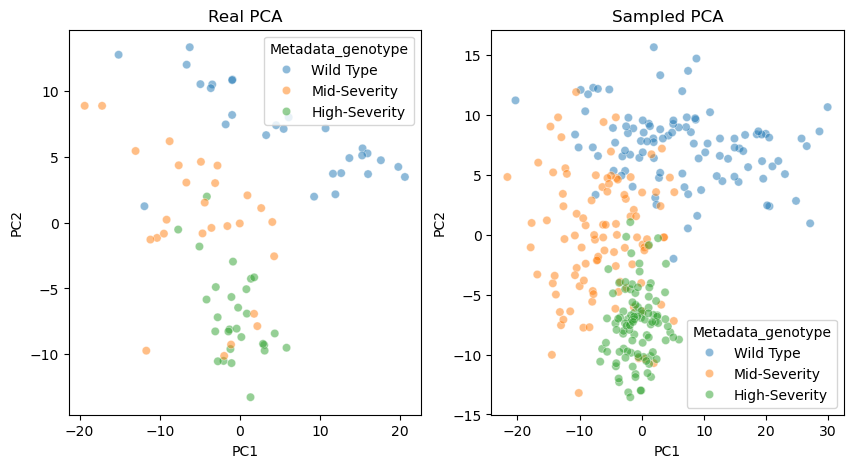

In [16]:
# annotate the genotypes of the sampled points
high_severity_sampled_points["Metadata_genotype"] = "High-Severity"
low_severity_sampled_points["Metadata_genotype"] = "Mid-Severity"
wt_sampled_points["Metadata_genotype"] = "Wild Type"
# concat the genotype sampled points
sampled_points = pd.concat(
    [wt_sampled_points, low_severity_sampled_points, high_severity_sampled_points]
)

# plot the first 2 PCA components from the actual data
# set up subplots
plt.figure(figsize=(10, 5))
# subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sum_aggregated_data_pca,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Real PCA")

# plot the first 2 PCA components from the sampled data
# subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sampled_points,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Sampled PCA")
plt.show()